DOWNLOAD ULTRALYTICS

---



In [ ]:
!pip install ultralytics opencv-python-headless


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 962.2 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

MOUNT GOOGLE DRIVE

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***NOTE TO WHOEVER IS GOING TO RUN THIS CODE***

---



In [ ]:
# import gdown
# import glob
# import zipfile
# import os


# #The google drive is shared with anyone on the internet. Firstly, download the drive details, put it in your drive and then run the below series of code.

# # Link to the shared Google Drive folder
# drive_link = 'https://drive.google.com/drive/u/0/folders/1607NiIlWhbA1g67S4Zxs-lPDeD5nqt2T'

# gdown.download_folder(drive_link, output='VOC2012', quiet=False)

# # Extract the downloaded zip file if necessary (Uncomment if needed)
# # with zipfile.ZipFile('VOC2012.zip', 'r') as zip_ref:
# #     zip_ref.extractall('VOC2012')

# # Count total images in the extracted folder
# total_images = len(glob.glob('VOC2012/VOCdevkit/VOC2012/JPEGImages/*.jpg'))
# print("Total images:", total_images)


COUNT TOTAL IMAGES OF VOC 2012 DATASET

---



In [ ]:
import glob
# count total images before processing

total_images = len(glob.glob('/content/drive/MyDrive/VOC2012/VOCdevkit/VOC2012/JPEGImages/*.jpg'))
print(total_images)

1964


**SET DATASET PATH**

In [ ]:
import os

# Define paths and conditions
output_dir = '/content/drive/MyDrive/VOC2012/YOLO'
conditions = ['sunny', 'cloudy', 'foggy', 'rainy', 'snowy']
classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
           "bus", "car", "cat", "chair", "cow",
           "diningtable", "dog", "horse", "motorbike", "person",
           "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


**EDIT RAW IMAGES FOR DIFFERENT WEATHER CONDITIONS**

In [ ]:
import os
import cv2
import glob
import random
from tqdm import tqdm
import numpy as np
import xml.etree.ElementTree as ET

# Define paths
VOC_ROOT = '/content/drive/MyDrive/VOC2012/VOCdevkit/VOC2012/'
IMAGES_DIR = VOC_ROOT + 'JPEGImages/'
ANNOTATIONS_DIR = VOC_ROOT + 'Annotations/'
OUTPUT_DIR = '/content/drive/MyDrive/VOC2012/YOLO/'

# Create necessary directories
weather_conditions = ['sunny', 'cloudy', 'foggy', 'rainy', 'snowy']


for condition in weather_conditions:
    os.makedirs(f"{OUTPUT_DIR}/{condition}/images/train", exist_ok=True)
    os.makedirs(f"{OUTPUT_DIR}/{condition}/images/val", exist_ok=True)
    os.makedirs(f"{OUTPUT_DIR}/{condition}/labels/train", exist_ok=True)
    os.makedirs(f"{OUTPUT_DIR}/{condition}/labels/val", exist_ok=True)

# Image augmentation functions
def add_sunny(image):
    return cv2.convertScaleAbs(image, alpha=1.2, beta=30)

def add_cloudy(image):
    return cv2.convertScaleAbs(image, alpha=0.8, beta=-20)

def add_foggy(image):
    fog_layer = np.full_like(image, 255, dtype=np.uint8)
    alpha = 0.5
    return cv2.addWeighted(image, alpha, fog_layer, 1 - alpha, 0)

def add_rainy(image):
    rain_layer = np.zeros_like(image, dtype=np.uint8)
    num_drops = 1000
    for _ in range(num_drops):
        x = np.random.randint(0, image.shape[1])
        y = np.random.randint(0, image.shape[0])
        rain_layer = cv2.line(rain_layer, (x, y), (x, y + 10), (255, 255, 255), 1)
    rain_layer = cv2.blur(rain_layer, (3, 3))
    return cv2.addWeighted(image, 0.8, rain_layer, 0.2, 0)

def add_snowy(image):
    snow_layer = np.zeros_like(image, dtype=np.uint8)
    num_flakes = 1500 # set number of flakes
    for _ in range(num_flakes):
        x = np.random.randint(0, image.shape[1])
        y = np.random.randint(0, image.shape[0])
        flake_size = np.random.randint(1, 4)  # size of snowflakes
        snow_layer[y:y + flake_size, x:x + flake_size] = 255
    snow_layer = cv2.GaussianBlur(snow_layer, (7, 7), 0)  # Gaussian Blur
    return cv2.addWeighted(image, 0.7, snow_layer, 0.3, 0)

def convert_voc_to_yolo_bbox(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0 - 1
    y = (box[2] + box[3]) / 2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def process_and_save_annotations(image_files, output_image_dir, output_label_dir, weather_effect_func):
    for image_file in tqdm(image_files, desc="Processing annotations"):
        annotation_file = ANNOTATIONS_DIR + os.path.basename(image_file).replace('.jpg', '.xml')
        tree = ET.parse(annotation_file)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)

        yolo_annotations = []

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            if int(difficult) == 1:
                continue
            cls = obj.find('name').text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                 float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
            bb = convert_voc_to_yolo_bbox((w, h), b)
            yolo_annotations.append(f"{cls_id} " + " ".join([str(a) for a in bb]) + '\n')

        if yolo_annotations:
            image = cv2.imread(image_file)
            image = weather_effect_func(image)

            cv2.imwrite(output_image_dir + os.path.basename(image_file), image)
            with open(output_label_dir + os.path.basename(image_file).replace('.jpg', '.txt'), 'w') as f:
                f.writelines(yolo_annotations)

# Define classes in VOC dataset
classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
           "bus", "car", "cat", "chair", "cow",
           "diningtable", "dog", "horse", "motorbike", "person",
           "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

# Listing all image files
image_files = glob.glob(IMAGES_DIR + '*.jpg')

# Split data into train and validation sets
random.shuffle(image_files)
split_index = int(len(image_files) * 0.8)
train_files = image_files[:split_index]
val_files = image_files[split_index:]

# Process and save images for each weather condition
weather_funcs = {
    'sunny': add_sunny,
    'cloudy': add_cloudy,
    'foggy': add_foggy,
    'rainy': add_rainy,
    'snowy': add_snowy
}

for condition, func in weather_funcs.items():
    print(f"Processing {condition} dataset...")
    process_and_save_annotations(train_files, f"{OUTPUT_DIR}/{condition}/images/train/", f"{OUTPUT_DIR}/{condition}/labels/train/", func)
    process_and_save_annotations(val_files, f"{OUTPUT_DIR}/{condition}/images/val/", f"{OUTPUT_DIR}/{condition}/labels/val/", func)

print("VOC2012 dataset converted to YOLO format for all weather conditions successfully.")


COUNT IMAGES AFTER PRE-PROCESSING

---



In [ ]:
def count_images_in_directory(directory):
    image_files = glob.glob(os.path.join(directory, '*.jpg')) #image directory
    return len(image_files)


In [ ]:
total_train_images = 0
total_val_images = 0

for condition in conditions:
    train_images_dir = os.path.join(output_dir, condition, 'images/train')
    val_images_dir = os.path.join(output_dir, condition, 'images/val')

    train_images_count = count_images_in_directory(train_images_dir)
    val_images_count = count_images_in_directory(val_images_dir)

    total_train_images += train_images_count
    total_val_images += val_images_count

    print(f"{condition.capitalize()} - Training images: {train_images_count}, Validation images: {val_images_count}")

total_images = total_train_images + total_val_images

print(f"Total training images: {total_train_images}")
print(f"Total validation images: {total_val_images}")
print(f"Total images in dataset: {total_images}")


Sunny - Training images: 1570, Validation images: 393
Cloudy - Training images: 1570, Validation images: 393
Foggy - Training images: 1570, Validation images: 393
Rainy - Training images: 1570, Validation images: 393
Snowy - Training images: 1570, Validation images: 393
Total training images: 7850
Total validation images: 1965
Total images in dataset: 9815


SHOW 5 RANDOM IMAGES FROM WEATHER FOLDERS

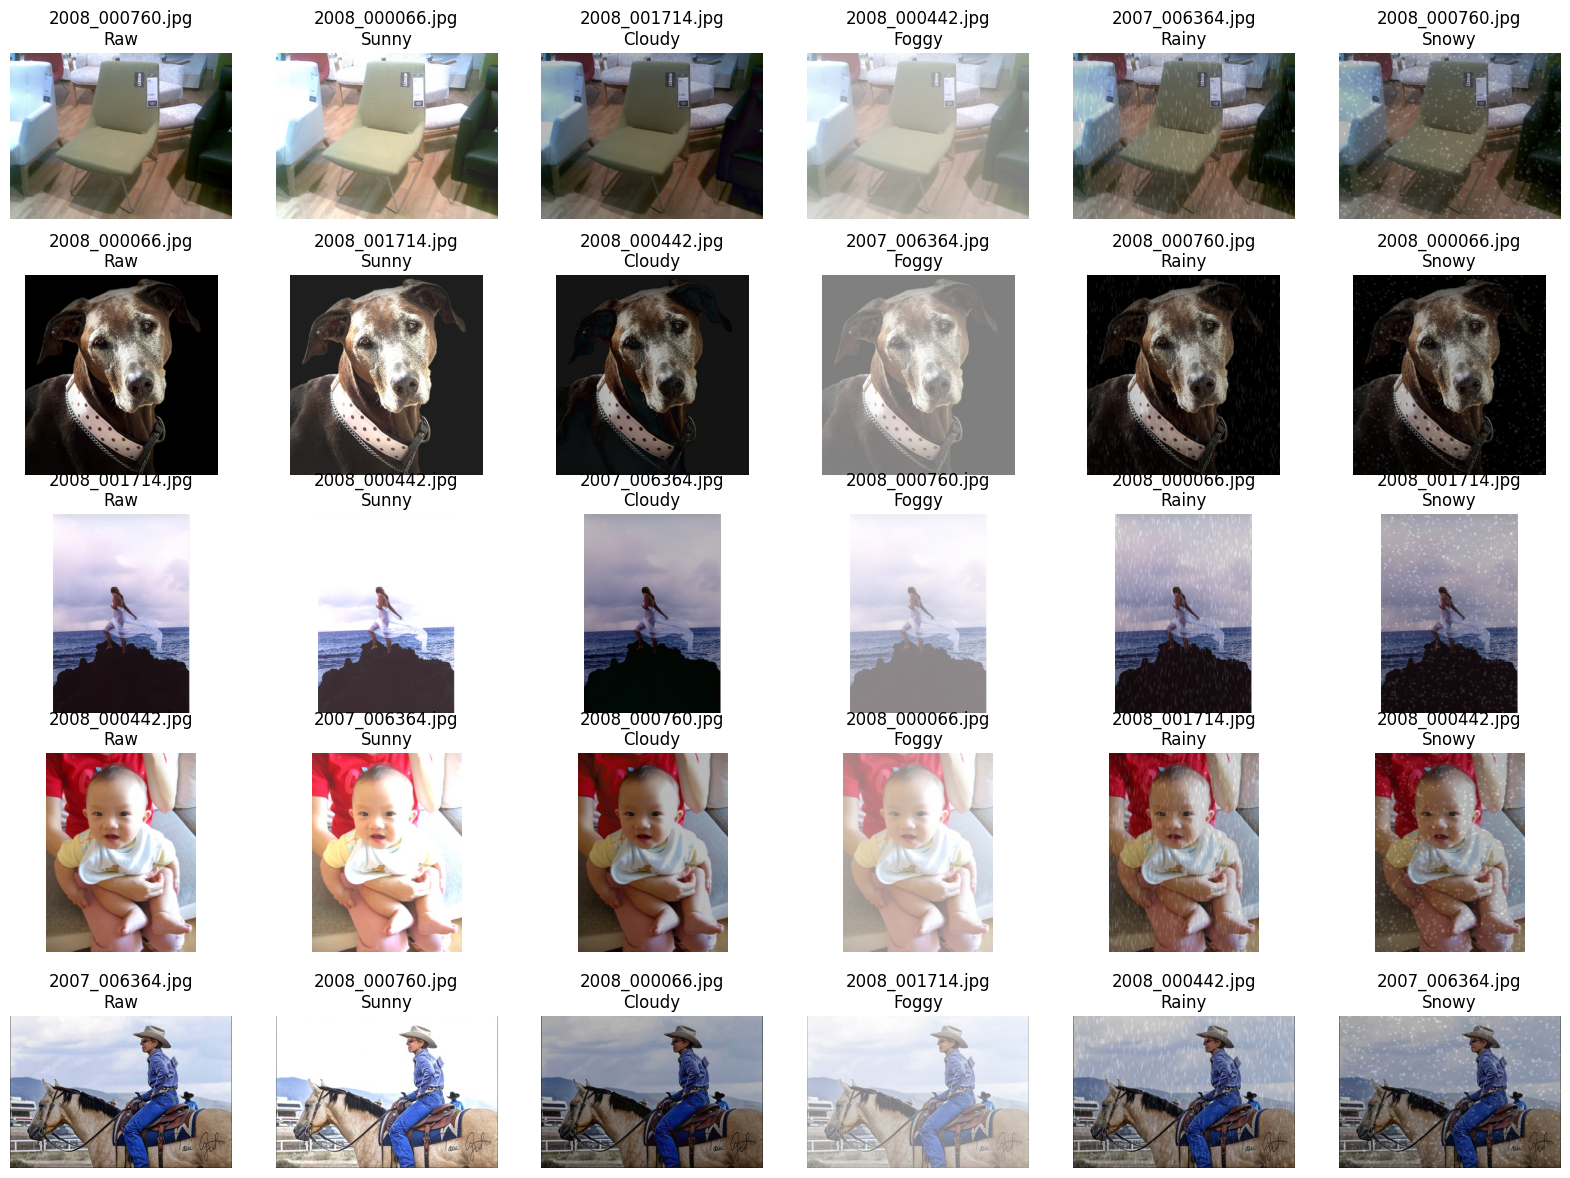

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define the base path and weather conditions
base_path = '/content/drive/MyDrive/VOC2012/YOLO'
raw_images_path = '/content/drive/MyDrive/VOC2012/VOCdevkit/VOC2012/JPEGImages'
weather_conditions = ['raw', 'sunny', 'cloudy', 'foggy', 'rainy', 'snowy']

# Get all image names from the raw images folder
all_images = os.listdir(raw_images_path)

# Select 5 random images
selected_images = random.sample(all_images, 5)

# Function to load and display images
def display_images(image_paths, image_names, conditions):
    plt.figure(figsize=(20, 15))
    for i, (image_path, image_name, condition) in enumerate(zip(image_paths, image_names, conditions)):
        if os.path.exists(image_path):
            img = Image.open(image_path)
            plt.subplot(len(selected_images), len(weather_conditions), i + 1)
            plt.imshow(img)
            plt.title(f"{image_name}\n{condition.capitalize()}")
            plt.axis('off')
        else:
            print(f"Image not found: {image_path}")
    plt.show()

# Function to find the image path in both 'train' and 'val' folders
def find_image_path(condition_path, image_name):
    for folder in ['train', 'val']:
        image_path = os.path.join(condition_path, 'images', folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None

# Gather image paths and conditions for the selected images
image_paths = []
conditions_list = []
for image_name in selected_images:
    for condition in weather_conditions:
        if condition == 'raw':
            image_path = os.path.join(raw_images_path, image_name)
        else:
            condition_path = os.path.join(base_path, condition)
            image_path = find_image_path(condition_path, image_name)
        if image_path:
            image_paths.append(image_path)
            conditions_list.append(condition)
        else:
            print(f"Image not found in {condition}: {image_name}")

# Display the images with their conditions
display_images(image_paths, selected_images * len(weather_conditions), conditions_list)


CREATE YAML FILE

In [ ]:
def create_yaml_files():
    for condition in conditions:
        yaml_content = f"""
path: {output_dir}/{condition}
train: images/train
val: images/val
nc: {len(classes)}
names: {classes}
"""
        with open(f"{output_dir}/{condition}/voc2012_{condition}.yaml", 'w') as f:
            f.write(yaml_content)

    print("YAML files created successfully.")

create_yaml_files()


YAML files created successfully.


HYPERPARAMETER TUNING

---



In [ ]:
# from ultralytics import YOLO

# def train_model(condition, epochs, lr):
#     yaml_file = f"{output_dir}/{condition}/voc2012_{condition}.yaml"
#     # save_dir = f"{output_dir}/{condition}/epochs_{epochs}_lr_{lr}"
#     project_dir = f"{output_dir}/{condition}/"
#     model_name = f'yolov8_voc2012_{condition}_epochs_{epochs}_lr_{lr}'

#     model = YOLO('yolov8s.pt')  # You can change this to 'yolov8n.pt', 'yolov8m.pt', etc.

#     # Train the model
#     model.train(
#         data=yaml_file,
#         epochs=epochs,
#         imgsz=640,
#         batch=16,
#         name=model_name,
#         lr0=lr,
#         augment=True,
#         project = project_dir,
#         device = 'cuda'
#     )
#     print(f"Training for {condition} with epochs={epochs} and lr={lr} completed successfully.")

# # Define the parameters
# epochs_list = [10, 20]
# learning_rates = [0.001, 0.01, 0.1]

# # Iterate over conditions, epochs, and learning rates
# for condition in conditions:
#     for epochs in epochs_list:
#         for lr in learning_rates:
#             train_model(condition, epochs, lr)


Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/VOC2012/YOLO/sunny/voc2012_sunny.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/content/drive/MyDrive/VOC2012/YOLO/sunny/, name=yolov8_voc2012_sunny_epochs_10_lr_0.001, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.001
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.55G     0.9327      3.222      1.254          3        640: 100%|██████████| 99/99 [00:14<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.89it/s]

                   all        393        926      0.738      0.607      0.682      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.01G     0.9423      1.567      1.249          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.20it/s]


                   all        393        926      0.554       0.61      0.608       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.97G     0.9918      1.452       1.29          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]

                   all        393        926      0.601      0.538       0.57      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.96G     0.9953      1.352      1.302          2        640: 100%|██████████| 99/99 [00:10<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        926      0.643      0.494      0.554      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.98G     0.9877      1.245      1.275          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.77it/s]

                   all        393        926       0.68      0.495      0.589      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.94G     0.9112      1.081      1.231          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]

                   all        393        926      0.618      0.593      0.634      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.97G     0.8655      0.966      1.192          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.01it/s]

                   all        393        926        0.7      0.625      0.696      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.96G     0.8117     0.8396      1.153          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]

                   all        393        926      0.734       0.63      0.705      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.98G     0.7631     0.7518      1.115          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]

                   all        393        926      0.726      0.679      0.725      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.94G     0.7354     0.6864      1.091          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]

                   all        393        926      0.778      0.634      0.739      0.545



10 epochs completed in 0.054 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


                   all        393        926      0.784      0.639      0.741      0.566
             aeroplane         14         15      0.925      0.819      0.907      0.764
               bicycle         14         16      0.851      0.562      0.631      0.497
                  bird         17         23      0.785      0.476      0.553      0.418
                  boat         16         23      0.595      0.391      0.547      0.372
                bottle         21         30      0.834      0.503      0.737      0.482
                   bus          7         10      0.692        0.7      0.858      0.731
                   car         31         63       0.86      0.794      0.854      0.652
                   cat         21         21      0.859      0.762      0.893      0.682
                 chair         28         48      0.644      0.491      0.574      0.401
                   cow          6         14      0.834      0.786      0.794       0.64
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.01
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.15G     0.9327      3.222      1.254          3        640: 100%|██████████| 99/99 [00:13<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        393        926      0.738      0.607      0.682      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.97G     0.9423      1.567      1.249          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.50it/s]

                   all        393        926      0.554       0.61      0.608       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.94G     0.9918      1.452       1.29          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        926      0.601      0.538       0.57      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.94G     0.9953      1.352      1.302          2        640: 100%|██████████| 99/99 [00:10<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.67it/s]

                   all        393        926      0.643      0.494      0.554      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.95G     0.9877      1.245      1.275          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.98it/s]

                   all        393        926       0.68      0.495      0.589      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.91G     0.9112      1.081      1.231          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

                   all        393        926      0.618      0.593      0.634      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.94G     0.8655      0.966      1.192          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]

                   all        393        926        0.7      0.625      0.696      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.93G     0.8117     0.8396      1.153          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]

                   all        393        926      0.734       0.63      0.705      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.94G     0.7631     0.7518      1.115          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        926      0.726      0.679      0.725      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.91G     0.7354     0.6864      1.091          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]

                   all        393        926      0.778      0.634      0.739      0.545



10 epochs completed in 0.069 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


                   all        393        926      0.784      0.639      0.741      0.566
             aeroplane         14         15      0.925      0.819      0.907      0.764
               bicycle         14         16      0.851      0.562      0.631      0.497
                  bird         17         23      0.785      0.476      0.553      0.418
                  boat         16         23      0.595      0.391      0.547      0.372
                bottle         21         30      0.834      0.503      0.737      0.482
                   bus          7         10      0.692        0.7      0.858      0.731
                   car         31         63       0.86      0.794      0.854      0.652
                   cat         21         21      0.859      0.762      0.893      0.682
                 chair         28         48      0.644      0.491      0.574      0.401
                   cow          6         14      0.834      0.786      0.794       0.64
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.1
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.15G     0.9327      3.222      1.254          3        640: 100%|██████████| 99/99 [00:13<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.03it/s]

                   all        393        926      0.738      0.607      0.682      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.97G     0.9423      1.567      1.249          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]

                   all        393        926      0.554       0.61      0.608       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.94G     0.9918      1.452       1.29          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]

                   all        393        926      0.601      0.538       0.57      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.94G     0.9953      1.352      1.302          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926      0.643      0.494      0.554      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.94G     0.9877      1.245      1.275          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]

                   all        393        926       0.68      0.495      0.589      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.92G     0.9112      1.081      1.231          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.04it/s]

                   all        393        926      0.618      0.593      0.634      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.94G     0.8655      0.966      1.192          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        393        926        0.7      0.625      0.696      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.94G     0.8117     0.8396      1.153          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]

                   all        393        926      0.734       0.63      0.705      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.95G     0.7631     0.7518      1.115          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]

                   all        393        926      0.726      0.679      0.725      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.92G     0.7354     0.6864      1.091          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.18it/s]

                   all        393        926      0.778      0.634      0.739      0.545



10 epochs completed in 0.069 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_10_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


                   all        393        926      0.784      0.639      0.741      0.566
             aeroplane         14         15      0.925      0.819      0.907      0.764
               bicycle         14         16      0.851      0.562      0.631      0.497
                  bird         17         23      0.785      0.476      0.553      0.418
                  boat         16         23      0.595      0.391      0.547      0.372
                bottle         21         30      0.834      0.503      0.737      0.482
                   bus          7         10      0.692        0.7      0.858      0.731
                   car         31         63       0.86      0.794      0.854      0.652
                   cat         21         21      0.859      0.762      0.893      0.682
                 chair         28         48      0.644      0.491      0.574      0.401
                   cow          6         14      0.834      0.786      0.794       0.64
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.001
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.14G     0.9157      2.264      1.227          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.95it/s]

                   all        393        926      0.767      0.638      0.744      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         4G     0.9388      1.411      1.238         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]


                   all        393        926      0.708      0.599      0.652      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.97G      0.961      1.318      1.258         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]

                   all        393        926      0.604      0.517       0.56      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.93G      0.996      1.282       1.27          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]

                   all        393        926      0.634      0.509      0.558      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         4G     0.9782      1.256       1.27          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.20it/s]

                   all        393        926      0.628      0.553      0.598      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.91G     0.9421      1.141      1.238         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.24it/s]

                   all        393        926      0.706      0.557      0.624       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.93G     0.9411      1.094      1.237         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]

                   all        393        926      0.678      0.595      0.645      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.96G     0.8997      1.048      1.214          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]

                   all        393        926      0.656      0.594      0.639      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.94G     0.8792     0.9983      1.204         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]


                   all        393        926       0.66      0.579      0.649      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.96G     0.8575     0.9387       1.19         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]

                   all        393        926      0.647      0.604      0.624      0.438


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.93G     0.8346     0.8577      1.175          8        640: 100%|██████████| 99/99 [00:12<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

                   all        393        926      0.683      0.586      0.657      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.93G     0.8138     0.8064      1.171          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.11it/s]

                   all        393        926       0.69       0.64      0.672      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.94G     0.7591     0.7144      1.125          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]

                   all        393        926      0.741      0.585      0.671      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.91G     0.7401     0.6656      1.099          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]

                   all        393        926      0.714      0.643        0.7      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.93G     0.7132     0.6357      1.074          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.11it/s]

                   all        393        926      0.756      0.578      0.673      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.93G     0.6878     0.5832      1.065          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        926      0.737      0.596      0.698      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.94G     0.6702     0.5547      1.052          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        926      0.757      0.574      0.679       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.91G     0.6357     0.5273      1.027          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]

                   all        393        926      0.774       0.61      0.697      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.94G     0.6018      0.485      1.011          9        640: 100%|██████████| 99/99 [00:10<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]

                   all        393        926      0.746      0.628      0.688      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.93G     0.5997     0.4682      1.005          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.87it/s]

                   all        393        926      0.775      0.621      0.713      0.515



20 epochs completed in 0.108 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


                   all        393        926       0.74      0.701      0.783      0.598
             aeroplane         14         15      0.854      0.779      0.883      0.717
               bicycle         14         16       0.68       0.75      0.812      0.591
                  bird         17         23      0.757      0.696      0.725      0.578
                  boat         16         23      0.601      0.656      0.729      0.413
                bottle         21         30        0.9      0.597      0.734        0.5
                   bus          7         10      0.921        0.9      0.935      0.775
                   car         31         63      0.784      0.693      0.818      0.594
                   cat         21         21      0.772      0.762      0.839      0.686
                 chair         28         48      0.588      0.683      0.673      0.504
                   cow          6         14       0.72      0.571      0.762      0.608
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.01
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.15G     0.9157      2.264      1.227          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.06it/s]


                   all        393        926      0.767      0.638      0.744      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.01G     0.9388      1.411      1.238         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        926      0.708      0.599      0.652      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.98G      0.961      1.318      1.258         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]

                   all        393        926      0.604      0.517       0.56      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.94G      0.996      1.282       1.27          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.11it/s]

                   all        393        926      0.634      0.509      0.558      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         4G     0.9782      1.256       1.27          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        393        926      0.628      0.553      0.598      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.92G     0.9421      1.141      1.238         17        640: 100%|██████████| 99/99 [00:10<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.31it/s]

                   all        393        926      0.706      0.557      0.624       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.94G     0.9411      1.094      1.237         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.97it/s]

                   all        393        926      0.678      0.595      0.645      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.96G     0.8997      1.048      1.214          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

                   all        393        926      0.656      0.594      0.639      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.95G     0.8792     0.9983      1.204         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.00it/s]

                   all        393        926       0.66      0.579      0.649      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.97G     0.8575     0.9387       1.19         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

                   all        393        926      0.647      0.604      0.624      0.438


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.94G     0.8346     0.8577      1.175          8        640: 100%|██████████| 99/99 [00:12<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.30it/s]

                   all        393        926      0.683      0.586      0.657      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.94G     0.8138     0.8064      1.171          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]

                   all        393        926       0.69       0.64      0.672      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.95G     0.7591     0.7144      1.125          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]

                   all        393        926      0.741      0.585      0.671      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.92G     0.7401     0.6656      1.099          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

                   all        393        926      0.714      0.643        0.7      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.94G     0.7132     0.6357      1.074          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.29it/s]

                   all        393        926      0.756      0.578      0.673      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.94G     0.6878     0.5832      1.065          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]

                   all        393        926      0.737      0.596      0.698      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.95G     0.6702     0.5547      1.052          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]

                   all        393        926      0.757      0.574      0.679       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.92G     0.6357     0.5273      1.027          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


                   all        393        926      0.774       0.61      0.697      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.94G     0.6018      0.485      1.011          9        640: 100%|██████████| 99/99 [00:10<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]

                   all        393        926      0.746      0.628      0.688      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.94G     0.5997     0.4682      1.005          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]

                   all        393        926      0.775      0.621      0.713      0.515



20 epochs completed in 0.108 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


                   all        393        926       0.74      0.701      0.783      0.598
             aeroplane         14         15      0.854      0.779      0.883      0.717
               bicycle         14         16       0.68       0.75      0.812      0.591
                  bird         17         23      0.757      0.696      0.725      0.578
                  boat         16         23      0.601      0.656      0.729      0.413
                bottle         21         30        0.9      0.597      0.734        0.5
                   bus          7         10      0.921        0.9      0.935      0.775
                   car         31         63      0.784      0.693      0.818      0.594
                   cat         21         21      0.772      0.762      0.839      0.686
                 chair         28         48      0.588      0.683      0.673      0.504
                   cow          6         14       0.72      0.571      0.762      0.608
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.15G     0.9157      2.264      1.227          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.44it/s]


                   all        393        926      0.767      0.638      0.744      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         4G     0.9388      1.411      1.238         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]

                   all        393        926      0.708      0.599      0.652      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.97G      0.961      1.318      1.258         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.23it/s]

                   all        393        926      0.604      0.517       0.56      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.94G      0.996      1.282       1.27          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.30it/s]

                   all        393        926      0.634      0.509      0.558      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.01G     0.9782      1.256       1.27          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]

                   all        393        926      0.628      0.553      0.598      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.92G     0.9421      1.141      1.238         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]

                   all        393        926      0.706      0.557      0.624       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.95G     0.9411      1.094      1.237         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        926      0.678      0.595      0.645      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.96G     0.8997      1.048      1.214          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.50it/s]

                   all        393        926      0.656      0.594      0.639      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.96G     0.8792     0.9983      1.204         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]

                   all        393        926       0.66      0.579      0.649      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.97G     0.8575     0.9387       1.19         18        640: 100%|██████████| 99/99 [00:10<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]

                   all        393        926      0.647      0.604      0.624      0.438


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.94G     0.8346     0.8577      1.175          8        640: 100%|██████████| 99/99 [00:12<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.20it/s]

                   all        393        926      0.683      0.586      0.657      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.93G     0.8138     0.8064      1.171          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]

                   all        393        926       0.69       0.64      0.672      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.96G     0.7591     0.7144      1.125          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        926      0.741      0.585      0.671      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.92G     0.7401     0.6656      1.099          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

                   all        393        926      0.714      0.643        0.7      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.94G     0.7132     0.6357      1.074          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        393        926      0.756      0.578      0.673      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.94G     0.6878     0.5832      1.065          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]

                   all        393        926      0.737      0.596      0.698      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.95G     0.6702     0.5547      1.052          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]

                   all        393        926      0.757      0.574      0.679       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.92G     0.6357     0.5273      1.027          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

                   all        393        926      0.774       0.61      0.697      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.95G     0.6018      0.485      1.011          9        640: 100%|██████████| 99/99 [00:10<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]

                   all        393        926      0.746      0.628      0.688      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.94G     0.5997     0.4682      1.005          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]

                   all        393        926      0.775      0.621      0.713      0.515



20 epochs completed in 0.109 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        393        926       0.74      0.701      0.783      0.598
             aeroplane         14         15      0.854      0.779      0.883      0.717
               bicycle         14         16       0.68       0.75      0.812      0.591
                  bird         17         23      0.757      0.696      0.725      0.578
                  boat         16         23      0.601      0.656      0.729      0.413
                bottle         21         30        0.9      0.597      0.734        0.5
                   bus          7         10      0.921        0.9      0.935      0.775
                   car         31         63      0.784      0.693      0.818      0.594
                   cat         21         21      0.772      0.762      0.839      0.686
                 chair         28         48      0.588      0.683      0.673      0.504
                   cow          6         14       0.72      0.571      0.762      0.608
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.16G     0.9157      2.264      1.227          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.11it/s]

                   all        393        926      0.767      0.638      0.744      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         4G     0.9412      1.408      1.238         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        926      0.665      0.616      0.653      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.97G     0.9566      1.313      1.256         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        926      0.647      0.578        0.6      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.94G     0.9987      1.324      1.275          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        926      0.601      0.538      0.573      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.99G      0.992      1.253      1.285          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

                   all        393        926      0.566      0.566      0.588      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.91G     0.9725      1.162      1.262         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        926      0.561      0.629      0.604      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.94G      0.955      1.129      1.255         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]

                   all        393        926      0.683       0.54      0.614      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.96G     0.9331      1.108      1.238          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]

                   all        393        926      0.575      0.557      0.585      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.95G     0.9107      1.033      1.228         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.20it/s]

                   all        393        926      0.694      0.578      0.628      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.96G     0.8987      1.004      1.217         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.22it/s]

                   all        393        926      0.712      0.564      0.644      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.96G     0.8816     0.9836      1.207          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.86it/s]

                   all        393        926      0.705      0.549       0.63      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.96G     0.8534     0.9355      1.192         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]

                   all        393        926      0.607      0.616       0.62      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.96G     0.8374     0.8919      1.172         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        393        926      0.688      0.614      0.646      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.94G      0.817     0.8613      1.163         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.04it/s]

                   all        393        926      0.737      0.554      0.643      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.96G     0.8081     0.8427      1.156          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

                   all        393        926      0.742      0.531      0.646      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G     0.8083     0.8142      1.164          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]

                   all        393        926      0.593       0.62      0.622      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.97G     0.7802     0.7946      1.139          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]

                   all        393        926      0.683      0.678      0.684      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.94G     0.7675     0.7672      1.129          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

                   all        393        926      0.682      0.605      0.667      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.94G     0.7404     0.7245      1.119         14        640: 100%|██████████| 99/99 [00:10<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.67it/s]

                   all        393        926      0.686      0.621      0.666      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.96G     0.7441     0.7122      1.118         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]

                   all        393        926      0.699      0.573      0.639      0.457


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.94G     0.6827     0.6126      1.072          2        640: 100%|██████████| 99/99 [00:13<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        393        926       0.65      0.617      0.652      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.92G     0.6551     0.5388      1.048          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

                   all        393        926       0.73      0.574      0.652      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.94G     0.6445     0.5296      1.054          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.04it/s]

                   all        393        926      0.696      0.604      0.643      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.93G     0.6221     0.4833      1.026          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        926      0.665      0.644      0.662      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.94G     0.5989     0.4692      1.005          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]

                   all        393        926      0.653      0.639      0.665      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.94G     0.5945     0.4497      1.006          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        926      0.686      0.632       0.67      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.94G     0.5712     0.4349     0.9842          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]

                   all        393        926      0.703      0.627      0.675      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.93G      0.547     0.4029     0.9843          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.02it/s]

                   all        393        926      0.687      0.643       0.68      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.96G     0.5402     0.4093      0.977          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]

                   all        393        926       0.71      0.657       0.69      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.92G     0.5368     0.3802     0.9646          2        640: 100%|██████████| 99/99 [00:10<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

                   all        393        926       0.72      0.649      0.692      0.519



30 epochs completed in 0.148 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


                   all        393        926       0.74      0.701      0.783      0.598
             aeroplane         14         15      0.854      0.779      0.883      0.717
               bicycle         14         16       0.68       0.75      0.812      0.591
                  bird         17         23      0.757      0.696      0.725      0.578
                  boat         16         23      0.601      0.656      0.729      0.413
                bottle         21         30        0.9      0.597      0.734        0.5
                   bus          7         10      0.921        0.9      0.935      0.775
                   car         31         63      0.784      0.693      0.818      0.594
                   cat         21         21      0.772      0.762      0.839      0.686
                 chair         28         48      0.588      0.683      0.673      0.504
                   cow          6         14       0.72      0.571      0.762      0.608
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.01
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.15G     0.9157      2.264      1.227          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.98it/s]

                   all        393        926      0.767      0.638      0.744      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.01G     0.9412      1.408      1.238         11        640: 100%|██████████| 99/99 [00:12<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.88it/s]

                   all        393        926      0.665      0.616      0.653      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.96G     0.9566      1.313      1.256         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        926      0.647      0.578        0.6      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.94G     0.9987      1.324      1.275          6        640: 100%|██████████| 99/99 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

                   all        393        926      0.601      0.538      0.573      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         4G      0.992      1.253      1.285          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]

                   all        393        926      0.566      0.566      0.588      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.92G     0.9725      1.162      1.262         17        640: 100%|██████████| 99/99 [00:10<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        926      0.561      0.629      0.604      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.94G      0.955      1.129      1.255         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.10it/s]

                   all        393        926      0.683       0.54      0.614      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.97G     0.9331      1.108      1.238          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        393        926      0.575      0.557      0.585      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.94G     0.9107      1.033      1.228         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        926      0.694      0.578      0.628      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.96G     0.8987      1.004      1.217         18        640: 100%|██████████| 99/99 [00:10<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]

                   all        393        926      0.712      0.564      0.644      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.96G     0.8816     0.9836      1.207          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]

                   all        393        926      0.705      0.549       0.63      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.96G     0.8534     0.9355      1.192         14        640: 100%|██████████| 99/99 [00:10<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.60it/s]


                   all        393        926      0.607      0.616       0.62      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.97G     0.8374     0.8919      1.172         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]

                   all        393        926      0.688      0.614      0.646      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.94G      0.817     0.8613      1.163         13        640: 100%|██████████| 99/99 [00:10<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        926      0.737      0.554      0.643      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.96G     0.8081     0.8427      1.156          9        640: 100%|██████████| 99/99 [00:10<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]

                   all        393        926      0.742      0.531      0.646      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G     0.8083     0.8142      1.164          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        926      0.593       0.62      0.622      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.97G     0.7802     0.7946      1.139          5        640: 100%|██████████| 99/99 [00:10<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]

                   all        393        926      0.683      0.678      0.684      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.94G     0.7675     0.7672      1.129          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]

                   all        393        926      0.682      0.605      0.667      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.94G     0.7404     0.7245      1.119         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        926      0.686      0.621      0.666      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.96G     0.7441     0.7122      1.118         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


                   all        393        926      0.699      0.573      0.639      0.457
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.95G     0.6827     0.6126      1.072          2        640: 100%|██████████| 99/99 [00:13<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

                   all        393        926       0.65      0.617      0.652      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.92G     0.6551     0.5388      1.048          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        926       0.73      0.574      0.652      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.94G     0.6445     0.5296      1.054          5        640: 100%|██████████| 99/99 [00:10<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]

                   all        393        926      0.696      0.604      0.643      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.95G     0.6221     0.4833      1.026          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]

                   all        393        926      0.665      0.644      0.662      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.94G     0.5989     0.4692      1.005          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        393        926      0.653      0.639      0.665      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.94G     0.5945     0.4497      1.006          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

                   all        393        926      0.686      0.632       0.67      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.94G     0.5712     0.4349     0.9842          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


                   all        393        926      0.703      0.627      0.675      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.94G      0.547     0.4029     0.9843          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        926      0.687      0.643       0.68      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.98G     0.5402     0.4093      0.977          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]

                   all        393        926       0.71      0.657       0.69      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.92G     0.5368     0.3802     0.9646          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]

                   all        393        926       0.72      0.649      0.692      0.519



30 epochs completed in 0.148 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


                   all        393        926       0.74      0.701      0.783      0.598
             aeroplane         14         15      0.854      0.779      0.883      0.717
               bicycle         14         16       0.68       0.75      0.812      0.591
                  bird         17         23      0.757      0.696      0.725      0.578
                  boat         16         23      0.601      0.656      0.729      0.413
                bottle         21         30        0.9      0.597      0.734        0.5
                   bus          7         10      0.921        0.9      0.935      0.775
                   car         31         63      0.784      0.693      0.818      0.594
                   cat         21         21      0.772      0.762      0.839      0.686
                 chair         28         48      0.588      0.683      0.673      0.504
                   cow          6         14       0.72      0.571      0.762      0.608
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.1
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.15G     0.9157      2.264      1.227          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


                   all        393        926      0.767      0.638      0.744      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         4G     0.9412      1.408      1.238         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]

                   all        393        926      0.665      0.616      0.653      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.97G     0.9566      1.313      1.256         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]

                   all        393        926      0.647      0.578        0.6      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.94G     0.9987      1.324      1.275          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        926      0.601      0.538      0.573      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         4G      0.992      1.253      1.285          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]

                   all        393        926      0.566      0.566      0.588      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.92G     0.9725      1.162      1.262         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

                   all        393        926      0.561      0.629      0.604      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.94G      0.955      1.129      1.255         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]

                   all        393        926      0.683       0.54      0.614      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.97G     0.9331      1.108      1.238          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]

                   all        393        926      0.575      0.557      0.585      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.95G     0.9107      1.033      1.228         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        393        926      0.694      0.578      0.628      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.97G     0.8987      1.004      1.217         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.07it/s]

                   all        393        926      0.712      0.564      0.644      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.96G     0.8816     0.9836      1.207          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]

                   all        393        926      0.705      0.549       0.63      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.96G     0.8534     0.9355      1.192         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        926      0.607      0.616       0.62      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.97G     0.8374     0.8919      1.172         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926      0.688      0.614      0.646      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.94G      0.817     0.8613      1.163         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]

                   all        393        926      0.737      0.554      0.643      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.96G     0.8081     0.8427      1.156          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

                   all        393        926      0.742      0.531      0.646      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G     0.8083     0.8142      1.164          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.32it/s]

                   all        393        926      0.593       0.62      0.622      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.97G     0.7802     0.7946      1.139          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]

                   all        393        926      0.683      0.678      0.684      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.94G     0.7675     0.7672      1.129          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.59it/s]

                   all        393        926      0.682      0.605      0.667      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.94G     0.7404     0.7245      1.119         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.04it/s]

                   all        393        926      0.686      0.621      0.666      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.96G     0.7441     0.7122      1.118         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.98it/s]

                   all        393        926      0.699      0.573      0.639      0.457


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.95G     0.6827     0.6126      1.072          2        640: 100%|██████████| 99/99 [00:13<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        393        926       0.65      0.617      0.652      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.92G     0.6551     0.5388      1.048          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        393        926       0.73      0.574      0.652      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.94G     0.6445     0.5296      1.054          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.87it/s]

                   all        393        926      0.696      0.604      0.643      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.94G     0.6221     0.4833      1.026          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

                   all        393        926      0.665      0.644      0.662      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.94G     0.5989     0.4692      1.005          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]

                   all        393        926      0.653      0.639      0.665      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.94G     0.5945     0.4497      1.006          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]

                   all        393        926      0.686      0.632       0.67      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.94G     0.5712     0.4349     0.9842          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        926      0.703      0.627      0.675      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.94G      0.547     0.4029     0.9843          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]

                   all        393        926      0.687      0.643       0.68      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.97G     0.5402     0.4093      0.977          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.67it/s]

                   all        393        926       0.71      0.657       0.69      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.92G     0.5368     0.3802     0.9646          2        640: 100%|██████████| 99/99 [00:10<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]

                   all        393        926       0.72      0.649      0.692      0.519



30 epochs completed in 0.150 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


                   all        393        926       0.74      0.701      0.783      0.598
             aeroplane         14         15      0.854      0.779      0.883      0.717
               bicycle         14         16       0.68       0.75      0.812      0.591
                  bird         17         23      0.757      0.696      0.725      0.578
                  boat         16         23      0.601      0.656      0.729      0.413
                bottle         21         30        0.9      0.597      0.734        0.5
                   bus          7         10      0.921        0.9      0.935      0.775
                   car         31         63      0.784      0.693      0.818      0.594
                   cat         21         21      0.772      0.762      0.839      0.686
                 chair         28         48      0.588      0.683      0.673      0.504
                   cow          6         14       0.72      0.571      0.762      0.608
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.001
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.15G      0.918      3.167      1.244          3        640: 100%|██████████| 99/99 [00:13<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]

                   all        393        926      0.631      0.638      0.664      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.99G     0.9365      1.573      1.252          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]

                   all        393        926      0.644      0.526      0.596      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.97G      0.985      1.453       1.29          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]

                   all        393        926      0.538      0.546      0.552      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.95G     0.9977      1.339      1.298          2        640: 100%|██████████| 99/99 [00:10<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.50it/s]

                   all        393        926      0.624      0.535      0.592      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.96G     0.9784      1.246       1.28          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]

                   all        393        926      0.654      0.524      0.605      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.93G      0.906      1.082      1.229          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        926       0.67      0.633      0.636      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.95G     0.8534     0.9611      1.181          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]

                   all        393        926      0.719      0.577      0.653      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.95G      0.794     0.8491      1.139          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]

                   all        393        926      0.744      0.623      0.681      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.95G     0.7583     0.7466       1.12          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

                   all        393        926      0.684      0.663      0.691      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.93G     0.7223     0.6877      1.082          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]

                   all        393        926      0.708      0.674      0.706      0.516



10 epochs completed in 0.085 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


                   all        393        926       0.76      0.674      0.737      0.559
             aeroplane         14         15      0.822      0.867      0.921      0.776
               bicycle         14         16      0.689      0.691      0.794      0.606
                  bird         17         23      0.775      0.478       0.57      0.447
                  boat         16         23      0.827      0.522      0.694      0.423
                bottle         21         30      0.863      0.533      0.751      0.464
                   bus          7         10      0.888      0.792      0.863        0.7
                   car         31         63      0.841      0.758      0.813      0.598
                   cat         21         21      0.801       0.81      0.846      0.684
                 chair         28         48      0.588      0.542      0.565      0.408
                   cow          6         14      0.719      0.733      0.723      0.536
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.01
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.16G      0.918      3.167      1.244          3        640: 100%|██████████| 99/99 [00:14<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.67it/s]


                   all        393        926      0.631      0.638      0.664      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.98G     0.9365      1.573      1.252          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.97it/s]

                   all        393        926      0.644      0.526      0.596      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.93G      0.985      1.453       1.29          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]

                   all        393        926      0.538      0.546      0.552      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.93G     0.9977      1.339      1.298          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.96it/s]

                   all        393        926      0.624      0.535      0.592      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.94G     0.9784      1.246       1.28          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]

                   all        393        926      0.654      0.524      0.605      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.91G      0.906      1.082      1.229          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        926       0.67      0.633      0.636      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.94G     0.8534     0.9611      1.181          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]

                   all        393        926      0.719      0.577      0.653      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.93G      0.794     0.8491      1.139          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

                   all        393        926      0.744      0.623      0.681      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.93G     0.7583     0.7466       1.12          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        926      0.684      0.663      0.691      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.92G     0.7223     0.6877      1.082          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        926      0.708      0.674      0.706      0.516



10 epochs completed in 0.070 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


                   all        393        926       0.76      0.674      0.737      0.559
             aeroplane         14         15      0.822      0.867      0.921      0.776
               bicycle         14         16      0.689      0.691      0.794      0.606
                  bird         17         23      0.775      0.478       0.57      0.447
                  boat         16         23      0.827      0.522      0.694      0.423
                bottle         21         30      0.863      0.533      0.751      0.464
                   bus          7         10      0.888      0.792      0.863        0.7
                   car         31         63      0.841      0.758      0.813      0.598
                   cat         21         21      0.801       0.81      0.846      0.684
                 chair         28         48      0.588      0.542      0.565      0.408
                   cow          6         14      0.719      0.733      0.723      0.536
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.1
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.15G      0.918      3.167      1.244          3        640: 100%|██████████| 99/99 [00:14<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.78it/s]

                   all        393        926      0.631      0.638      0.664      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.99G     0.9365      1.573      1.252          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.32it/s]

                   all        393        926      0.644      0.526      0.596      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.96G      0.985      1.453       1.29          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

                   all        393        926      0.538      0.546      0.552      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.94G     0.9977      1.339      1.298          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        926      0.624      0.535      0.592      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.96G     0.9784      1.246       1.28          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        926      0.654      0.524      0.605      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.92G      0.906      1.082      1.229          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        393        926       0.67      0.633      0.636      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.94G     0.8534     0.9611      1.181          6        640: 100%|██████████| 99/99 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        926      0.719      0.577      0.653      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.94G      0.794     0.8491      1.139          6        640: 100%|██████████| 99/99 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]

                   all        393        926      0.744      0.623      0.681      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.95G     0.7583     0.7466       1.12          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]

                   all        393        926      0.684      0.663      0.691      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.92G     0.7223     0.6877      1.082          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        926      0.708      0.674      0.706      0.516



10 epochs completed in 0.070 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_10_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


                   all        393        926       0.76      0.674      0.737      0.559
             aeroplane         14         15      0.822      0.867      0.921      0.776
               bicycle         14         16      0.689      0.691      0.794      0.606
                  bird         17         23      0.775      0.478       0.57      0.447
                  boat         16         23      0.827      0.522      0.694      0.423
                bottle         21         30      0.863      0.533      0.751      0.464
                   bus          7         10      0.888      0.792      0.863        0.7
                   car         31         63      0.841      0.758      0.813      0.598
                   cat         21         21      0.801       0.81      0.846      0.684
                 chair         28         48      0.588      0.542      0.565      0.408
                   cow          6         14      0.719      0.733      0.723      0.536
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.001
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.15G      0.903       2.26      1.223          9        640: 100%|██████████| 99/99 [00:14<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.08it/s]

                   all        393        926      0.718      0.625      0.694      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.01G     0.9296      1.384      1.233         11        640: 100%|██████████| 99/99 [00:12<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        926      0.597      0.636      0.648      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.97G     0.9526      1.298      1.251         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926       0.61      0.584       0.61      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.94G     0.9748      1.264      1.256          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        926      0.648      0.535      0.593      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         4G     0.9726      1.239      1.273          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]


                   all        393        926      0.704      0.559      0.614      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.92G     0.9434      1.121      1.241         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        393        926      0.639      0.555      0.603      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.94G     0.9299      1.074      1.229         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.77it/s]

                   all        393        926      0.704      0.539      0.619      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.96G     0.8853      1.027      1.206          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]

                   all        393        926       0.68      0.583      0.615      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.94G     0.8758     0.9714      1.204         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        393        926      0.756      0.572      0.653      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.96G     0.8543     0.9225      1.184         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


                   all        393        926      0.655      0.607      0.626      0.433
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.93G     0.8208     0.8561      1.175          8        640: 100%|██████████| 99/99 [00:13<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

                   all        393        926      0.715      0.554       0.61      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.93G     0.7901     0.7875      1.151          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        926      0.647      0.591      0.626      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.94G     0.7599     0.7069      1.126          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]

                   all        393        926      0.692      0.595      0.654      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.91G     0.7312     0.6528      1.087          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]

                   all        393        926      0.698      0.593      0.664      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.94G     0.6998     0.6186      1.063          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        926      0.659      0.602      0.661      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.94G     0.6699     0.5628      1.051          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.60it/s]

                   all        393        926      0.729      0.618      0.683      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.95G       0.66      0.539      1.046          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.86it/s]


                   all        393        926       0.74      0.612      0.692      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.92G     0.6294     0.4966      1.023          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.26it/s]

                   all        393        926      0.749      0.625      0.685      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.94G     0.6058     0.4813      1.016          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.15it/s]

                   all        393        926      0.768      0.607      0.703      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.93G      0.582       0.46     0.9975          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.05it/s]

                   all        393        926      0.716       0.65        0.7      0.517



20 epochs completed in 0.111 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


                   all        393        926      0.768      0.647      0.717      0.549
             aeroplane         14         15      0.848        0.8      0.852      0.735
               bicycle         14         16      0.829      0.562      0.643      0.495
                  bird         17         23      0.828      0.435      0.518      0.333
                  boat         16         23      0.794      0.505      0.644      0.387
                bottle         21         30      0.942      0.543      0.716      0.446
                   bus          7         10      0.803          1      0.995      0.869
                   car         31         63      0.794      0.732      0.842      0.641
                   cat         21         21      0.617      0.619      0.705      0.586
                 chair         28         48      0.636      0.458      0.558      0.406
                   cow          6         14      0.654      0.857      0.747      0.589
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.01
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.15G      0.903       2.26      1.223          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.10it/s]

                   all        393        926      0.718      0.625      0.694      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.01G     0.9296      1.384      1.233         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]

                   all        393        926      0.597      0.636      0.648      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.97G     0.9526      1.298      1.251         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926       0.61      0.584       0.61      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.94G     0.9748      1.264      1.256          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.32it/s]

                   all        393        926      0.648      0.535      0.593      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         4G     0.9726      1.239      1.273          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]

                   all        393        926      0.704      0.559      0.614      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.92G     0.9434      1.121      1.241         17        640: 100%|██████████| 99/99 [00:12<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.50it/s]

                   all        393        926      0.639      0.555      0.603      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.95G     0.9299      1.074      1.229         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

                   all        393        926      0.704      0.539      0.619      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.96G     0.8853      1.027      1.206          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]

                   all        393        926       0.68      0.583      0.615      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.95G     0.8758     0.9714      1.204         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]

                   all        393        926      0.756      0.572      0.653      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.97G     0.8543     0.9225      1.184         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        926      0.655      0.607      0.626      0.433


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.94G     0.8208     0.8561      1.175          8        640: 100%|██████████| 99/99 [00:12<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.60it/s]

                   all        393        926      0.715      0.554       0.61      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.94G     0.7901     0.7875      1.151          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]

                   all        393        926      0.647      0.591      0.626      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.94G     0.7599     0.7069      1.126          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        926      0.692      0.595      0.654      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.92G     0.7312     0.6528      1.087          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]

                   all        393        926      0.698      0.593      0.664      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.93G     0.6998     0.6186      1.063          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]

                   all        393        926      0.659      0.602      0.661      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.93G     0.6699     0.5628      1.051          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]

                   all        393        926      0.729      0.618      0.683      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.94G       0.66      0.539      1.046          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.67it/s]

                   all        393        926       0.74      0.612      0.692      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.91G     0.6294     0.4966      1.023          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]

                   all        393        926      0.749      0.625      0.685      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.94G     0.6058     0.4813      1.016          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.05it/s]

                   all        393        926      0.768      0.607      0.703      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.94G      0.582       0.46     0.9975          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.28it/s]

                   all        393        926      0.716       0.65        0.7      0.517



20 epochs completed in 0.111 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


                   all        393        926      0.768      0.647      0.717      0.549
             aeroplane         14         15      0.848        0.8      0.852      0.735
               bicycle         14         16      0.829      0.562      0.643      0.495
                  bird         17         23      0.828      0.435      0.518      0.333
                  boat         16         23      0.794      0.505      0.644      0.387
                bottle         21         30      0.942      0.543      0.716      0.446
                   bus          7         10      0.803          1      0.995      0.869
                   car         31         63      0.794      0.732      0.842      0.641
                   cat         21         21      0.617      0.619      0.705      0.586
                 chair         28         48      0.636      0.458      0.558      0.406
                   cow          6         14      0.654      0.857      0.747      0.589
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.15G      0.903       2.26      1.223          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.73it/s]


                   all        393        926      0.718      0.625      0.694      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         4G     0.9296      1.384      1.233         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

                   all        393        926      0.597      0.636      0.648      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.96G     0.9526      1.298      1.251         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]

                   all        393        926       0.61      0.584       0.61      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.94G     0.9748      1.264      1.256          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.11it/s]

                   all        393        926      0.648      0.535      0.593      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.99G     0.9726      1.239      1.273          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926      0.704      0.559      0.614      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.91G     0.9434      1.121      1.241         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]

                   all        393        926      0.639      0.555      0.603      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.94G     0.9299      1.074      1.229         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.11it/s]

                   all        393        926      0.704      0.539      0.619      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.96G     0.8853      1.027      1.206          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

                   all        393        926       0.68      0.583      0.615      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.94G     0.8758     0.9714      1.204         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]

                   all        393        926      0.756      0.572      0.653      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.96G     0.8543     0.9225      1.184         18        640: 100%|██████████| 99/99 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        926      0.655      0.607      0.626      0.433


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.94G     0.8208     0.8561      1.175          8        640: 100%|██████████| 99/99 [00:12<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]

                   all        393        926      0.715      0.554       0.61      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.94G     0.7901     0.7875      1.151          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.87it/s]

                   all        393        926      0.647      0.591      0.626      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.94G     0.7599     0.7069      1.126          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]

                   all        393        926      0.692      0.595      0.654      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.91G     0.7312     0.6528      1.087          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]

                   all        393        926      0.698      0.593      0.664      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.93G     0.6998     0.6186      1.063          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        393        926      0.659      0.602      0.661      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.93G     0.6699     0.5628      1.051          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        926      0.729      0.618      0.683      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.94G       0.66      0.539      1.046          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]

                   all        393        926       0.74      0.612      0.692      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.92G     0.6294     0.4966      1.023          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.67it/s]

                   all        393        926      0.749      0.625      0.685      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.94G     0.6058     0.4813      1.016          9        640: 100%|██████████| 99/99 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]

                   all        393        926      0.768      0.607      0.703      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.93G      0.582       0.46     0.9975          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.15it/s]

                   all        393        926      0.716       0.65        0.7      0.517



20 epochs completed in 0.110 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_20_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


                   all        393        926      0.768      0.647      0.717      0.549
             aeroplane         14         15      0.848        0.8      0.852      0.735
               bicycle         14         16      0.829      0.562      0.643      0.495
                  bird         17         23      0.828      0.435      0.518      0.333
                  boat         16         23      0.794      0.505      0.644      0.387
                bottle         21         30      0.942      0.543      0.716      0.446
                   bus          7         10      0.803          1      0.995      0.869
                   car         31         63      0.794      0.732      0.842      0.641
                   cat         21         21      0.617      0.619      0.705      0.586
                 chair         28         48      0.636      0.458      0.558      0.406
                   cow          6         14      0.654      0.857      0.747      0.589
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.15G      0.903       2.26      1.223          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.87it/s]

                   all        393        926      0.718      0.625      0.694      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         4G     0.9338      1.389      1.235         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]

                   all        393        926      0.694      0.619      0.674      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.96G     0.9573      1.322      1.256         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]

                   all        393        926      0.622      0.537      0.587      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.94G     0.9957      1.289      1.273          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.27it/s]

                   all        393        926      0.578      0.547      0.558      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         4G     0.9967      1.302      1.287          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]

                   all        393        926      0.566      0.526      0.563      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.92G     0.9674      1.172      1.262         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]

                   all        393        926      0.599      0.529      0.539      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.94G     0.9517       1.13      1.252         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.98it/s]

                   all        393        926      0.651      0.542      0.607      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.96G     0.9155      1.086      1.228          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]

                   all        393        926      0.604      0.546      0.572      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.94G     0.9057      1.027       1.23         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

                   all        393        926      0.723      0.564      0.644      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.96G     0.8887     0.9925      1.212         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]

                   all        393        926      0.679       0.54      0.618       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.96G     0.8891     0.9797      1.214          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]

                   all        393        926      0.657       0.59      0.645      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.96G     0.8504     0.9371      1.196         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]

                   all        393        926      0.694      0.557      0.612      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.97G     0.8309     0.8911      1.172         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        926       0.75      0.566      0.643      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.94G     0.8062     0.8631      1.159         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]

                   all        393        926      0.648      0.607      0.636      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.96G      0.801     0.8348      1.153          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.50it/s]

                   all        393        926      0.716      0.538      0.626      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G      0.803     0.8225      1.157          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

                   all        393        926      0.738       0.55      0.639      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.97G     0.7692     0.7974      1.134          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]

                   all        393        926      0.771      0.581      0.673      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.94G     0.7614     0.7561      1.125          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]

                   all        393        926      0.654      0.642      0.661      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.94G      0.729     0.7149      1.112         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]

                   all        393        926      0.679      0.619      0.669      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.96G     0.7405     0.7161      1.118         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]

                   all        393        926      0.688      0.593      0.644      0.453


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.94G     0.6817     0.6186       1.07          2        640: 100%|██████████| 99/99 [00:13<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.77it/s]

                   all        393        926      0.703       0.58      0.644      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.92G     0.6567      0.548      1.048          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        393        926      0.723      0.587      0.647      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.94G     0.6353     0.5099      1.035          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.27it/s]

                   all        393        926      0.666      0.605      0.652      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.94G     0.6107     0.4749      1.016          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

                   all        393        926      0.746      0.563      0.662      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.94G     0.5893     0.4678      1.005          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        926      0.692      0.598      0.665      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.94G     0.5941     0.4572      1.015          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]

                   all        393        926      0.654      0.613      0.669      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.94G     0.5582     0.4297     0.9785          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        926      0.691      0.608       0.68      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.94G     0.5453     0.3991     0.9799          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

                   all        393        926      0.738      0.606      0.687      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.97G     0.5313     0.4076     0.9696          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]

                   all        393        926      0.727      0.612      0.683      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.91G     0.5262     0.3835     0.9623          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        393        926      0.681      0.624      0.677      0.491



30 epochs completed in 0.151 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


                   all        393        926      0.676      0.687      0.734      0.554
             aeroplane         14         15          1      0.526      0.946      0.801
               bicycle         14         16      0.526       0.75      0.746      0.466
                  bird         17         23      0.672      0.652      0.714       0.53
                  boat         16         23      0.588      0.696      0.703      0.458
                bottle         21         30      0.868      0.667      0.699      0.443
                   bus          7         10      0.583        0.8       0.66      0.447
                   car         31         63      0.768      0.825      0.836      0.608
                   cat         21         21      0.798      0.857       0.85      0.689
                 chair         28         48      0.501      0.583      0.567      0.419
                   cow          6         14      0.797      0.562      0.837      0.662
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.01
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.15G      0.903       2.26      1.223          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.03it/s]

                   all        393        926      0.718      0.625      0.694      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.01G     0.9338      1.389      1.235         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

                   all        393        926      0.694      0.619      0.674      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.97G     0.9573      1.322      1.256         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]

                   all        393        926      0.622      0.537      0.587      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.94G     0.9957      1.289      1.273          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]

                   all        393        926      0.578      0.547      0.558      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.01G     0.9967      1.302      1.287          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]

                   all        393        926      0.566      0.526      0.563      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.92G     0.9674      1.172      1.262         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        393        926      0.599      0.529      0.539      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.94G     0.9517       1.13      1.252         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.27it/s]

                   all        393        926      0.651      0.542      0.607      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.96G     0.9155      1.086      1.228          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]

                   all        393        926      0.604      0.546      0.572      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.95G     0.9057      1.027       1.23         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        393        926      0.723      0.564      0.644      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.97G     0.8887     0.9925      1.212         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        926      0.679       0.54      0.618       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.97G     0.8891     0.9797      1.214          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.22it/s]

                   all        393        926      0.657       0.59      0.645      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.97G     0.8504     0.9371      1.196         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        393        926      0.694      0.557      0.612      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.97G     0.8309     0.8911      1.172         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

                   all        393        926       0.75      0.566      0.643      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.94G     0.8062     0.8631      1.159         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]

                   all        393        926      0.648      0.607      0.636      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.97G      0.801     0.8348      1.153          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]

                   all        393        926      0.716      0.538      0.626      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G      0.803     0.8225      1.157          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]


                   all        393        926      0.738       0.55      0.639      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.97G     0.7692     0.7974      1.134          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

                   all        393        926      0.771      0.581      0.673      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.95G     0.7614     0.7561      1.125          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        926      0.654      0.642      0.661      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.96G      0.729     0.7149      1.112         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]

                   all        393        926      0.679      0.619      0.669      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.96G     0.7405     0.7161      1.118         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        926      0.688      0.593      0.644      0.453


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.95G     0.6817     0.6186       1.07          2        640: 100%|██████████| 99/99 [00:12<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.21it/s]

                   all        393        926      0.703       0.58      0.644      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.92G     0.6567      0.548      1.048          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

                   all        393        926      0.723      0.587      0.647      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.94G     0.6353     0.5099      1.035          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

                   all        393        926      0.666      0.605      0.652      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.94G     0.6107     0.4749      1.016          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        926      0.746      0.563      0.662      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.94G     0.5893     0.4678      1.005          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]

                   all        393        926      0.692      0.598      0.665      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.94G     0.5941     0.4572      1.015          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]

                   all        393        926      0.654      0.613      0.669      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.95G     0.5582     0.4297     0.9785          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        926      0.691      0.608       0.68      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.94G     0.5453     0.3991     0.9799          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.20it/s]

                   all        393        926      0.738      0.606      0.687      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.97G     0.5313     0.4076     0.9696          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.67it/s]

                   all        393        926      0.727      0.612      0.683      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.92G     0.5262     0.3835     0.9623          2        640: 100%|██████████| 99/99 [00:10<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        926      0.681      0.624      0.677      0.491



30 epochs completed in 0.151 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


                   all        393        926      0.676      0.687      0.734      0.554
             aeroplane         14         15          1      0.526      0.946      0.801
               bicycle         14         16      0.526       0.75      0.746      0.466
                  bird         17         23      0.672      0.652      0.714       0.53
                  boat         16         23      0.588      0.696      0.703      0.458
                bottle         21         30      0.868      0.667      0.699      0.443
                   bus          7         10      0.583        0.8       0.66      0.447
                   car         31         63      0.768      0.825      0.836      0.608
                   cat         21         21      0.798      0.857       0.85      0.689
                 chair         28         48      0.501      0.583      0.567      0.419
                   cow          6         14      0.797      0.562      0.837      0.662
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.1
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.15G      0.903       2.26      1.223          9        640: 100%|██████████| 99/99 [00:14<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.97it/s]


                   all        393        926      0.718      0.625      0.694      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.01G     0.9338      1.389      1.235         11        640: 100%|██████████| 99/99 [00:12<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]

                   all        393        926      0.694      0.619      0.674      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.96G     0.9573      1.322      1.256         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        926      0.622      0.537      0.587      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.94G     0.9957      1.289      1.273          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]

                   all        393        926      0.578      0.547      0.558      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         4G     0.9967      1.302      1.287          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        926      0.566      0.526      0.563      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.91G     0.9674      1.172      1.262         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]

                   all        393        926      0.599      0.529      0.539      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.94G     0.9517       1.13      1.252         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

                   all        393        926      0.651      0.542      0.607      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.96G     0.9155      1.086      1.228          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.32it/s]

                   all        393        926      0.604      0.546      0.572      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.95G     0.9057      1.027       1.23         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        393        926      0.723      0.564      0.644      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.96G     0.8887     0.9925      1.212         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]

                   all        393        926      0.679       0.54      0.618       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.96G     0.8891     0.9797      1.214          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]

                   all        393        926      0.657       0.59      0.645      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.95G     0.8504     0.9371      1.196         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

                   all        393        926      0.694      0.557      0.612      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.97G     0.8309     0.8911      1.172         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.24it/s]

                   all        393        926       0.75      0.566      0.643      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.94G     0.8062     0.8631      1.159         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        393        926      0.648      0.607      0.636      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.97G      0.801     0.8348      1.153          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        926      0.716      0.538      0.626      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G      0.803     0.8225      1.157          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]

                   all        393        926      0.738       0.55      0.639      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.97G     0.7692     0.7974      1.134          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]

                   all        393        926      0.771      0.581      0.673      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.93G     0.7614     0.7561      1.125          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]

                   all        393        926      0.654      0.642      0.661      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.94G      0.729     0.7149      1.112         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]

                   all        393        926      0.679      0.619      0.669      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.96G     0.7405     0.7161      1.118         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        926      0.688      0.593      0.644      0.453


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.95G     0.6817     0.6186       1.07          2        640: 100%|██████████| 99/99 [00:13<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        926      0.703       0.58      0.644      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.92G     0.6567      0.548      1.048          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.00it/s]

                   all        393        926      0.723      0.587      0.647      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.94G     0.6353     0.5099      1.035          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        926      0.666      0.605      0.652      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.94G     0.6107     0.4749      1.016          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]

                   all        393        926      0.746      0.563      0.662      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.95G     0.5893     0.4678      1.005          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]

                   all        393        926      0.692      0.598      0.665      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.94G     0.5941     0.4572      1.015          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.50it/s]

                   all        393        926      0.654      0.613      0.669      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.93G     0.5582     0.4297     0.9785          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]

                   all        393        926      0.691      0.608       0.68      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.93G     0.5453     0.3991     0.9799          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]

                   all        393        926      0.738      0.606      0.687      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.97G     0.5313     0.4076     0.9696          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]

                   all        393        926      0.727      0.612      0.683      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.92G     0.5262     0.3835     0.9623          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]

                   all        393        926      0.681      0.624      0.677      0.491



30 epochs completed in 0.151 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy_epochs_30_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


                   all        393        926      0.676      0.687      0.734      0.554
             aeroplane         14         15          1      0.526      0.946      0.801
               bicycle         14         16      0.526       0.75      0.746      0.466
                  bird         17         23      0.672      0.652      0.714       0.53
                  boat         16         23      0.588      0.696      0.703      0.458
                bottle         21         30      0.868      0.667      0.699      0.443
                   bus          7         10      0.583        0.8       0.66      0.447
                   car         31         63      0.768      0.825      0.836      0.608
                   cat         21         21      0.798      0.857       0.85      0.689
                 chair         28         48      0.501      0.583      0.567      0.419
                   cow          6         14      0.797      0.562      0.837      0.662
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.001
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.15G     0.9259       3.11      1.249          3        640: 100%|██████████| 99/99 [00:13<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]

                   all        393        926      0.632      0.671      0.695      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         4G     0.9404      1.552      1.254          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]

                   all        393        926      0.586      0.516      0.562      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.95G      1.018      1.483      1.311          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]

                   all        393        926      0.628      0.513      0.578      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.95G       1.02      1.372      1.323          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]

                   all        393        926      0.614       0.57      0.598      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.96G     0.9816      1.268       1.29          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.59it/s]

                   all        393        926      0.631      0.596      0.623      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.93G     0.9137      1.097      1.231          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]

                   all        393        926      0.733      0.559      0.647      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.96G     0.8797     0.9999      1.203          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]

                   all        393        926      0.711      0.586      0.682      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.94G     0.8217     0.8934      1.164          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        393        926      0.724      0.615      0.696      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.96G     0.7704     0.7761      1.129          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.96it/s]

                   all        393        926      0.754       0.63      0.714      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.92G     0.7363     0.7033      1.095          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]

                   all        393        926      0.773      0.666      0.738      0.543



10 epochs completed in 0.083 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


                   all        393        926      0.785      0.663      0.751      0.579
             aeroplane         14         15      0.805      0.733      0.817      0.743
               bicycle         14         16      0.831      0.562      0.742      0.563
                  bird         17         23      0.627      0.435      0.504      0.426
                  boat         16         23      0.815      0.522      0.677      0.403
                bottle         21         30      0.798      0.567      0.708      0.463
                   bus          7         10      0.906        0.8      0.932      0.778
                   car         31         63      0.894      0.746      0.869      0.651
                   cat         21         21      0.727       0.89      0.822      0.677
                 chair         28         48      0.648      0.574      0.575      0.432
                   cow          6         14      0.734      0.786      0.849      0.633
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.01
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.15G     0.9259       3.11      1.249          3        640: 100%|██████████| 99/99 [00:13<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.98it/s]


                   all        393        926      0.632      0.671      0.695      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.97G     0.9404      1.552      1.254          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.77it/s]

                   all        393        926      0.586      0.516      0.562      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.93G      1.018      1.483      1.311          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        926      0.628      0.513      0.578      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.93G       1.02      1.372      1.323          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        926      0.614       0.57      0.598      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.94G     0.9816      1.268       1.29          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.00it/s]

                   all        393        926      0.631      0.596      0.623      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       3.9G     0.9137      1.097      1.231          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        926      0.733      0.559      0.647      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.93G     0.8797     0.9999      1.203          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        393        926      0.711      0.586      0.682      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.93G     0.8217     0.8934      1.164          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

                   all        393        926      0.724      0.615      0.696      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.94G     0.7704     0.7761      1.129          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.88it/s]

                   all        393        926      0.754       0.63      0.714      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.91G     0.7363     0.7033      1.095          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        393        926      0.773      0.666      0.738      0.543



10 epochs completed in 0.071 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


                   all        393        926      0.785      0.663      0.751      0.579
             aeroplane         14         15      0.805      0.733      0.817      0.743
               bicycle         14         16      0.831      0.562      0.742      0.563
                  bird         17         23      0.627      0.435      0.504      0.426
                  boat         16         23      0.815      0.522      0.677      0.403
                bottle         21         30      0.798      0.567      0.708      0.463
                   bus          7         10      0.906        0.8      0.932      0.778
                   car         31         63      0.894      0.746      0.869      0.651
                   cat         21         21      0.727       0.89      0.822      0.677
                 chair         28         48      0.648      0.574      0.575      0.432
                   cow          6         14      0.734      0.786      0.849      0.633
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.1
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.15G     0.9259       3.11      1.249          3        640: 100%|██████████| 99/99 [00:14<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.21it/s]

                   all        393        926      0.632      0.671      0.695      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.97G     0.9404      1.552      1.254          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]


                   all        393        926      0.586      0.516      0.562      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.94G      1.018      1.483      1.311          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.32it/s]

                   all        393        926      0.628      0.513      0.578      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.93G       1.02      1.372      1.323          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.77it/s]

                   all        393        926      0.614       0.57      0.598      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.94G     0.9816      1.268       1.29          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.59it/s]

                   all        393        926      0.631      0.596      0.623      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       3.9G     0.9137      1.097      1.231          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.04it/s]

                   all        393        926      0.733      0.559      0.647      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.94G     0.8797     0.9999      1.203          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        393        926      0.711      0.586      0.682      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.93G     0.8217     0.8934      1.164          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]

                   all        393        926      0.724      0.615      0.696      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.94G     0.7704     0.7761      1.129          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]

                   all        393        926      0.754       0.63      0.714      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       3.9G     0.7363     0.7033      1.095          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.21it/s]

                   all        393        926      0.773      0.666      0.738      0.543



10 epochs completed in 0.071 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_10_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


                   all        393        926      0.785      0.663      0.751      0.579
             aeroplane         14         15      0.805      0.733      0.817      0.743
               bicycle         14         16      0.831      0.562      0.742      0.563
                  bird         17         23      0.627      0.435      0.504      0.426
                  boat         16         23      0.815      0.522      0.677      0.403
                bottle         21         30      0.798      0.567      0.708      0.463
                   bus          7         10      0.906        0.8      0.932      0.778
                   car         31         63      0.894      0.746      0.869      0.651
                   cat         21         21      0.727       0.89      0.822      0.677
                 chair         28         48      0.648      0.574      0.575      0.432
                   cow          6         14      0.734      0.786      0.849      0.633
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.001
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.14G     0.9202      2.274      1.231          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.05it/s]

                   all        393        926      0.713      0.659      0.723      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         4G     0.9468      1.439      1.245         11        640: 100%|██████████| 99/99 [00:12<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.09it/s]

                   all        393        926      0.662      0.537      0.608      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.97G     0.9642      1.333      1.265         11        640: 100%|██████████| 99/99 [00:12<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.79it/s]

                   all        393        926      0.627      0.535      0.611      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.94G     0.9977      1.303      1.273          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        926      0.586      0.544      0.581      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.99G     0.9871      1.275      1.281          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]

                   all        393        926      0.638       0.53      0.566      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.91G     0.9589      1.141      1.252         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]


                   all        393        926      0.613      0.588      0.623      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.94G     0.9291      1.113      1.236         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        393        926      0.673       0.59      0.617      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.95G     0.8977      1.072      1.217          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]


                   all        393        926      0.659       0.58      0.617       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.94G     0.8845      1.018      1.215         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        926      0.718      0.568      0.641      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.95G      0.863     0.9662      1.193         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926      0.704       0.62      0.673      0.467


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.93G     0.8432      0.893      1.187          8        640: 100%|██████████| 99/99 [00:12<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        926      0.667      0.598      0.637      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.93G     0.8156     0.8298      1.174          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        393        926      0.726      0.602      0.678      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.94G     0.7797     0.7538      1.148          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]

                   all        393        926      0.707      0.595      0.662      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.91G     0.7515     0.6994      1.105          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

                   all        393        926      0.706      0.618      0.678      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.94G     0.7112     0.6286      1.077          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]

                   all        393        926      0.728      0.623      0.679      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.94G     0.6973      0.596      1.072          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        926      0.713      0.605      0.668      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.94G     0.6859     0.5892      1.067          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]

                   all        393        926      0.722      0.648      0.704      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.91G     0.6445     0.5429      1.043          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

                   all        393        926      0.733       0.63        0.7      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.93G      0.626     0.5053      1.028          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        926      0.748      0.656       0.71      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.93G     0.6109     0.4872      1.015          7        640: 100%|██████████| 99/99 [00:12<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]

                   all        393        926      0.738      0.655      0.705      0.532



20 epochs completed in 0.112 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


                   all        393        926      0.717      0.731      0.764      0.584
             aeroplane         14         15      0.925       0.82      0.905      0.754
               bicycle         14         16      0.676       0.75      0.798      0.543
                  bird         17         23      0.834      0.609      0.727      0.589
                  boat         16         23      0.875      0.522      0.712      0.467
                bottle         21         30       0.68      0.567      0.619      0.381
                   bus          7         10      0.804        0.9      0.882      0.735
                   car         31         63      0.781      0.825      0.871      0.653
                   cat         21         21      0.735      0.857      0.865      0.729
                 chair         28         48      0.571      0.609      0.694      0.491
                   cow          6         14      0.668      0.864      0.844      0.694
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.01
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.15G     0.9202      2.274      1.231          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.95it/s]


                   all        393        926      0.713      0.659      0.723      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         4G     0.9468      1.439      1.245         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.28it/s]

                   all        393        926      0.662      0.537      0.608      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.98G     0.9642      1.333      1.265         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]

                   all        393        926      0.627      0.535      0.611      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.94G     0.9977      1.303      1.273          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]

                   all        393        926      0.586      0.544      0.581      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.99G     0.9871      1.275      1.281          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.07it/s]

                   all        393        926      0.638       0.53      0.566      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.91G     0.9589      1.141      1.252         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]

                   all        393        926      0.613      0.588      0.623      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.94G     0.9291      1.113      1.236         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.09it/s]

                   all        393        926      0.673       0.59      0.617      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.96G     0.8977      1.072      1.217          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.60it/s]

                   all        393        926      0.659       0.58      0.617       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.95G     0.8845      1.018      1.215         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        926      0.718      0.568      0.641      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.96G      0.863     0.9662      1.193         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.16it/s]

                   all        393        926      0.704       0.62      0.673      0.467


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.95G     0.8432      0.893      1.187          8        640: 100%|██████████| 99/99 [00:13<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.17it/s]

                   all        393        926      0.667      0.598      0.637      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.94G     0.8156     0.8298      1.174          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

                   all        393        926      0.726      0.602      0.678      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.94G     0.7797     0.7538      1.148          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]

                   all        393        926      0.707      0.595      0.662      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.92G     0.7515     0.6994      1.105          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

                   all        393        926      0.706      0.618      0.678      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.95G     0.7112     0.6286      1.077          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]

                   all        393        926      0.728      0.623      0.679      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.94G     0.6973      0.596      1.072          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]

                   all        393        926      0.713      0.605      0.668      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.95G     0.6859     0.5892      1.067          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        393        926      0.722      0.648      0.704      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.92G     0.6445     0.5429      1.043          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        393        926      0.733       0.63        0.7      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.94G      0.626     0.5053      1.028          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]

                   all        393        926      0.748      0.656       0.71      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.94G     0.6109     0.4872      1.015          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        926      0.738      0.655      0.705      0.532



20 epochs completed in 0.111 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


                   all        393        926      0.717      0.731      0.764      0.584
             aeroplane         14         15      0.925       0.82      0.905      0.754
               bicycle         14         16      0.676       0.75      0.798      0.543
                  bird         17         23      0.834      0.609      0.727      0.589
                  boat         16         23      0.875      0.522      0.712      0.467
                bottle         21         30       0.68      0.567      0.619      0.381
                   bus          7         10      0.804        0.9      0.882      0.735
                   car         31         63      0.781      0.825      0.871      0.653
                   cat         21         21      0.735      0.857      0.865      0.729
                 chair         28         48      0.571      0.609      0.694      0.491
                   cow          6         14      0.668      0.864      0.844      0.694
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.15G     0.9202      2.274      1.231          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]


                   all        393        926      0.713      0.659      0.723      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         4G     0.9468      1.439      1.245         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        393        926      0.662      0.537      0.608      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.96G     0.9642      1.333      1.265         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.22it/s]

                   all        393        926      0.627      0.535      0.611      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.93G     0.9977      1.303      1.273          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

                   all        393        926      0.586      0.544      0.581      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         4G     0.9871      1.275      1.281          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.02it/s]

                   all        393        926      0.638       0.53      0.566      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.91G     0.9589      1.141      1.252         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]

                   all        393        926      0.613      0.588      0.623      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.94G     0.9291      1.113      1.236         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]

                   all        393        926      0.673       0.59      0.617      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.95G     0.8977      1.072      1.217          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]

                   all        393        926      0.659       0.58      0.617       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.95G     0.8845      1.018      1.215         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]

                   all        393        926      0.718      0.568      0.641      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.96G      0.863     0.9662      1.193         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.04it/s]

                   all        393        926      0.704       0.62      0.673      0.467


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.93G     0.8432      0.893      1.187          8        640: 100%|██████████| 99/99 [00:13<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        926      0.667      0.598      0.637      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.93G     0.8156     0.8298      1.174          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        926      0.726      0.602      0.678      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.95G     0.7797     0.7538      1.148          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        926      0.707      0.595      0.662      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.91G     0.7515     0.6994      1.105          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]

                   all        393        926      0.706      0.618      0.678      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.93G     0.7112     0.6286      1.077          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        393        926      0.728      0.623      0.679      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.94G     0.6973      0.596      1.072          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.00it/s]

                   all        393        926      0.713      0.605      0.668      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.94G     0.6859     0.5892      1.067          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.25it/s]

                   all        393        926      0.722      0.648      0.704      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.91G     0.6445     0.5429      1.043          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]

                   all        393        926      0.733       0.63        0.7      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.93G      0.626     0.5053      1.028          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]

                   all        393        926      0.748      0.656       0.71      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.93G     0.6109     0.4872      1.015          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        926      0.738      0.655      0.705      0.532



20 epochs completed in 0.111 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_20_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


                   all        393        926      0.717      0.731      0.764      0.584
             aeroplane         14         15      0.925       0.82      0.905      0.754
               bicycle         14         16      0.676       0.75      0.798      0.543
                  bird         17         23      0.834      0.609      0.727      0.589
                  boat         16         23      0.875      0.522      0.712      0.467
                bottle         21         30       0.68      0.567      0.619      0.381
                   bus          7         10      0.804        0.9      0.882      0.735
                   car         31         63      0.781      0.825      0.871      0.653
                   cat         21         21      0.735      0.857      0.865      0.729
                 chair         28         48      0.571      0.609      0.694      0.491
                   cow          6         14      0.668      0.864      0.844      0.694
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.16G     0.9202      2.274      1.231          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.08it/s]

                   all        393        926      0.713      0.659      0.723      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.02G      0.959      1.438      1.254         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        926      0.644      0.589      0.633      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.97G     0.9678      1.357      1.266         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        393        926      0.607      0.559       0.59      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.95G      1.014      1.325      1.285          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        393        926      0.504      0.494      0.483      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         4G     0.9925      1.334       1.29          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.03it/s]

                   all        393        926      0.665        0.5      0.562      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.93G     0.9757       1.22      1.269         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        926      0.649      0.508      0.578      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.95G     0.9592      1.171       1.26         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        926      0.596      0.588      0.611      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.97G     0.9361      1.119      1.242          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

                   all        393        926      0.599      0.555      0.588       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.96G     0.9202      1.078      1.241         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        926      0.646      0.573      0.593      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.97G     0.8999      1.034      1.218         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]

                   all        393        926      0.621      0.607      0.611       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.97G     0.8919       1.02      1.217          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

                   all        393        926      0.651      0.573       0.61      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.97G     0.8618     0.9652      1.206         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        393        926      0.682      0.573      0.635      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.97G     0.8423     0.9267      1.182         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

                   all        393        926      0.691      0.592      0.638      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.95G     0.8179     0.8877      1.172         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]

                   all        393        926      0.726      0.575      0.657      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.97G     0.8172     0.8813      1.166          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]

                   all        393        926      0.685      0.604      0.644      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G     0.8078     0.8445      1.163          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]

                   all        393        926      0.678      0.628      0.657      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.98G     0.7953     0.8265      1.153          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.77it/s]

                   all        393        926      0.702      0.619      0.673      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.95G     0.7709     0.7884      1.138          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926      0.697      0.594      0.647      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.95G      0.741       0.75      1.122         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]

                   all        393        926      0.654      0.648      0.679      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.97G     0.7496     0.7427      1.123         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]

                   all        393        926      0.724      0.561      0.658      0.484


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.96G     0.6879     0.6295      1.075          2        640: 100%|██████████| 99/99 [00:13<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]

                   all        393        926      0.669       0.59      0.646      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.93G     0.6753     0.5908      1.065          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]

                   all        393        926      0.717      0.598      0.676      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.95G     0.6452      0.547      1.045          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]

                   all        393        926      0.697      0.621      0.671      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.95G     0.6273     0.5094       1.03          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        926       0.66      0.649       0.68      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.99G     0.6143     0.4993      1.021          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]

                   all        393        926      0.738      0.607      0.686      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.95G     0.6133     0.4834      1.028          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]

                   all        393        926      0.735      0.629      0.698       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.95G     0.5829     0.4548     0.9936          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        926       0.72      0.628      0.698      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.94G     0.5644     0.4197     0.9912          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]

                   all        393        926      0.717      0.638      0.702      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.98G     0.5562     0.4335     0.9868          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.98it/s]

                   all        393        926      0.758      0.625      0.707      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.92G     0.5466     0.4024     0.9761          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        393        926      0.725      0.646      0.707      0.527



30 epochs completed in 0.151 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


                   all        393        926      0.717      0.731      0.764      0.584
             aeroplane         14         15      0.925       0.82      0.905      0.754
               bicycle         14         16      0.676       0.75      0.798      0.543
                  bird         17         23      0.834      0.609      0.727      0.589
                  boat         16         23      0.875      0.522      0.712      0.467
                bottle         21         30       0.68      0.567      0.619      0.381
                   bus          7         10      0.804        0.9      0.882      0.735
                   car         31         63      0.781      0.825      0.871      0.653
                   cat         21         21      0.735      0.857      0.865      0.729
                 chair         28         48      0.571      0.609      0.694      0.491
                   cow          6         14      0.668      0.864      0.844      0.694
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.01
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.16G     0.9202      2.274      1.231          9        640: 100%|██████████| 99/99 [00:14<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]

                   all        393        926      0.713      0.659      0.723      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.01G      0.959      1.438      1.254         11        640: 100%|██████████| 99/99 [00:12<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]

                   all        393        926      0.644      0.589      0.633      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.97G     0.9678      1.357      1.266         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        926      0.607      0.559       0.59      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.94G      1.014      1.325      1.285          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

                   all        393        926      0.504      0.494      0.483      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         4G     0.9925      1.334       1.29          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]

                   all        393        926      0.665        0.5      0.562      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.92G     0.9757       1.22      1.269         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        393        926      0.649      0.508      0.578      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.94G     0.9592      1.171       1.26         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        926      0.596      0.588      0.611      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.96G     0.9361      1.119      1.242          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        393        926      0.599      0.555      0.588       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.95G     0.9202      1.078      1.241         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]

                   all        393        926      0.646      0.573      0.593      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.96G     0.8999      1.034      1.218         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.00it/s]

                   all        393        926      0.621      0.607      0.611       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.96G     0.8919       1.02      1.217          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]

                   all        393        926      0.651      0.573       0.61      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.96G     0.8618     0.9652      1.206         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        393        926      0.682      0.573      0.635      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.97G     0.8423     0.9267      1.182         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.50it/s]

                   all        393        926      0.691      0.592      0.638      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.94G     0.8179     0.8877      1.172         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

                   all        393        926      0.726      0.575      0.657      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.96G     0.8172     0.8813      1.166          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.59it/s]

                   all        393        926      0.685      0.604      0.644      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G     0.8078     0.8445      1.163          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        926      0.678      0.628      0.657      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.97G     0.7953     0.8265      1.153          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]

                   all        393        926      0.702      0.619      0.673      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.94G     0.7709     0.7884      1.138          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        926      0.697      0.594      0.647      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.94G      0.741       0.75      1.122         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]

                   all        393        926      0.654      0.648      0.679      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.96G     0.7496     0.7427      1.123         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]

                   all        393        926      0.724      0.561      0.658      0.484


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.95G     0.6879     0.6295      1.075          2        640: 100%|██████████| 99/99 [00:13<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        393        926      0.669       0.59      0.646      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.92G     0.6753     0.5908      1.065          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]

                   all        393        926      0.717      0.598      0.676      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.94G     0.6452      0.547      1.045          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]

                   all        393        926      0.697      0.621      0.671      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.94G     0.6273     0.5094       1.03          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        926       0.66      0.649       0.68      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.97G     0.6143     0.4993      1.021          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]

                   all        393        926      0.738      0.607      0.686      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.94G     0.6133     0.4834      1.028          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        393        926      0.735      0.629      0.698       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.94G     0.5829     0.4548     0.9936          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.13it/s]

                   all        393        926       0.72      0.628      0.698      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.94G     0.5644     0.4197     0.9912          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]

                   all        393        926      0.717      0.638      0.702      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.97G     0.5562     0.4335     0.9868          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.10it/s]

                   all        393        926      0.758      0.625      0.707      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.92G     0.5466     0.4024     0.9761          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926      0.725      0.646      0.707      0.527



30 epochs completed in 0.152 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


                   all        393        926      0.717      0.731      0.764      0.584
             aeroplane         14         15      0.925       0.82      0.905      0.754
               bicycle         14         16      0.676       0.75      0.798      0.543
                  bird         17         23      0.834      0.609      0.727      0.589
                  boat         16         23      0.875      0.522      0.712      0.467
                bottle         21         30       0.68      0.567      0.619      0.381
                   bus          7         10      0.804        0.9      0.882      0.735
                   car         31         63      0.781      0.825      0.871      0.653
                   cat         21         21      0.735      0.857      0.865      0.729
                 chair         28         48      0.571      0.609      0.694      0.491
                   cow          6         14      0.668      0.864      0.844      0.694
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.1
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.16G     0.9202      2.274      1.231          9        640: 100%|██████████| 99/99 [00:14<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.22it/s]

                   all        393        926      0.713      0.659      0.723      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.02G      0.959      1.438      1.254         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

                   all        393        926      0.644      0.589      0.633      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.98G     0.9678      1.357      1.266         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.97it/s]

                   all        393        926      0.607      0.559       0.59      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.94G      1.014      1.325      1.285          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]

                   all        393        926      0.504      0.494      0.483      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.01G     0.9925      1.334       1.29          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]

                   all        393        926      0.665        0.5      0.562      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.93G     0.9757       1.22      1.269         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.26it/s]

                   all        393        926      0.649      0.508      0.578      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.95G     0.9592      1.171       1.26         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]

                   all        393        926      0.596      0.588      0.611      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.97G     0.9361      1.119      1.242          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

                   all        393        926      0.599      0.555      0.588       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.96G     0.9202      1.078      1.241         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        926      0.646      0.573      0.593      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.97G     0.8999      1.034      1.218         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        926      0.621      0.607      0.611       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.97G     0.8919       1.02      1.217          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]

                   all        393        926      0.651      0.573       0.61      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.97G     0.8618     0.9652      1.206         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]

                   all        393        926      0.682      0.573      0.635      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.98G     0.8423     0.9267      1.182         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.94it/s]

                   all        393        926      0.691      0.592      0.638      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.95G     0.8179     0.8877      1.172         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]

                   all        393        926      0.726      0.575      0.657      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.97G     0.8172     0.8813      1.166          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        926      0.685      0.604      0.644      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G     0.8078     0.8445      1.163          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]


                   all        393        926      0.678      0.628      0.657      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.98G     0.7953     0.8265      1.153          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]

                   all        393        926      0.702      0.619      0.673      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.94G     0.7709     0.7884      1.138          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]

                   all        393        926      0.697      0.594      0.647      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.94G      0.741       0.75      1.122         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.26it/s]

                   all        393        926      0.654      0.648      0.679      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.97G     0.7496     0.7427      1.123         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]

                   all        393        926      0.724      0.561      0.658      0.484


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.96G     0.6879     0.6295      1.075          2        640: 100%|██████████| 99/99 [00:13<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        393        926      0.669       0.59      0.646      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.93G     0.6753     0.5908      1.065          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.04it/s]

                   all        393        926      0.717      0.598      0.676      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.95G     0.6452      0.547      1.045          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.60it/s]

                   all        393        926      0.697      0.621      0.671      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.94G     0.6273     0.5094       1.03          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]

                   all        393        926       0.66      0.649       0.68      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.98G     0.6143     0.4993      1.021          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]

                   all        393        926      0.738      0.607      0.686      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.95G     0.6133     0.4834      1.028          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.03it/s]

                   all        393        926      0.735      0.629      0.698       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.94G     0.5829     0.4548     0.9936          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]

                   all        393        926       0.72      0.628      0.698      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.95G     0.5644     0.4197     0.9912          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

                   all        393        926      0.717      0.638      0.702      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.98G     0.5562     0.4335     0.9868          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

                   all        393        926      0.758      0.625      0.707      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.93G     0.5466     0.4024     0.9761          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        926      0.725      0.646      0.707      0.527



30 epochs completed in 0.152 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/foggy/yolov8_voc2012_foggy_epochs_30_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


                   all        393        926      0.717      0.731      0.764      0.584
             aeroplane         14         15      0.925       0.82      0.905      0.754
               bicycle         14         16      0.676       0.75      0.798      0.543
                  bird         17         23      0.834      0.609      0.727      0.589
                  boat         16         23      0.875      0.522      0.712      0.467
                bottle         21         30       0.68      0.567      0.619      0.381
                   bus          7         10      0.804        0.9      0.882      0.735
                   car         31         63      0.781      0.825      0.871      0.653
                   cat         21         21      0.735      0.857      0.865      0.729
                 chair         28         48      0.571      0.609      0.694      0.491
                   cow          6         14      0.668      0.864      0.844      0.694
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.001
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.16G     0.9306      3.106      1.261          3        640: 100%|██████████| 99/99 [00:13<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:14<00:00,  1.09s/it]

                   all        393        926       0.73       0.57      0.665      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.99G     0.9395        1.6      1.255          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        926      0.618      0.566      0.596      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.94G      1.006      1.459      1.309          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

                   all        393        926      0.624      0.518      0.548      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.93G      1.003      1.352      1.304          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        393        926       0.55      0.568      0.559      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.94G       0.98      1.244      1.274          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]

                   all        393        926       0.65      0.505      0.579      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.92G     0.9133      1.103      1.242          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        393        926      0.652      0.607      0.641      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.94G     0.8656     0.9584      1.198          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]

                   all        393        926      0.708      0.629      0.687      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.94G     0.8166     0.8633       1.16          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]

                   all        393        926      0.685       0.62      0.678      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.95G     0.7713     0.7591      1.124          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        393        926      0.706       0.65      0.717      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.92G     0.7294     0.6875      1.091          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.18it/s]

                   all        393        926      0.806      0.614      0.735      0.541



10 epochs completed in 0.087 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


                   all        393        926      0.783      0.657      0.753      0.573
             aeroplane         14         15      0.881        0.8      0.876      0.781
               bicycle         14         16      0.745      0.625      0.701      0.521
                  bird         17         23      0.778      0.478      0.598      0.438
                  boat         16         23      0.769      0.478      0.616      0.385
                bottle         21         30      0.729      0.467      0.634      0.383
                   bus          7         10      0.973        0.8      0.897      0.707
                   car         31         63      0.765      0.725      0.823       0.62
                   cat         21         21       0.77      0.639      0.795      0.611
                 chair         28         48      0.618      0.542      0.629      0.457
                   cow          6         14      0.823      0.857      0.892       0.69
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.01
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.16G     0.9306      3.106      1.261          3        640: 100%|██████████| 99/99 [00:14<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        393        926       0.73       0.57      0.665      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.99G     0.9395        1.6      1.255          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.50it/s]

                   all        393        926      0.618      0.566      0.596      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.95G      1.006      1.459      1.309          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]

                   all        393        926      0.624      0.518      0.548      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.94G      1.003      1.352      1.304          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]

                   all        393        926       0.55      0.568      0.559      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.95G       0.98      1.244      1.274          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]

                   all        393        926       0.65      0.505      0.579      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.92G     0.9133      1.103      1.242          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        926      0.652      0.607      0.641      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.95G     0.8656     0.9584      1.198          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]

                   all        393        926      0.708      0.629      0.687      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.94G     0.8166     0.8633       1.16          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        926      0.685       0.62      0.678      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.95G     0.7713     0.7591      1.124          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        926      0.706       0.65      0.717      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.92G     0.7294     0.6875      1.091          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.15it/s]

                   all        393        926      0.806      0.614      0.735      0.541



10 epochs completed in 0.071 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


                   all        393        926      0.783      0.657      0.753      0.573
             aeroplane         14         15      0.881        0.8      0.876      0.781
               bicycle         14         16      0.745      0.625      0.701      0.521
                  bird         17         23      0.778      0.478      0.598      0.438
                  boat         16         23      0.769      0.478      0.616      0.385
                bottle         21         30      0.729      0.467      0.634      0.383
                   bus          7         10      0.973        0.8      0.897      0.707
                   car         31         63      0.765      0.725      0.823       0.62
                   cat         21         21       0.77      0.639      0.795      0.611
                 chair         28         48      0.618      0.542      0.629      0.457
                   cow          6         14      0.823      0.857      0.892       0.69
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.1
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.15G     0.9306      3.106      1.261          3        640: 100%|██████████| 99/99 [00:14<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.93it/s]


                   all        393        926       0.73       0.57      0.665      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.97G     0.9395        1.6      1.255          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.26it/s]

                   all        393        926      0.618      0.566      0.596      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.94G      1.006      1.459      1.309          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.11it/s]

                   all        393        926      0.624      0.518      0.548      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.93G      1.003      1.352      1.304          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        393        926       0.55      0.568      0.559      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.93G       0.98      1.244      1.274          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]

                   all        393        926       0.65      0.505      0.579      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       3.9G     0.9133      1.103      1.242          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.28it/s]

                   all        393        926      0.652      0.607      0.641      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.93G     0.8656     0.9584      1.198          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        393        926      0.708      0.629      0.687      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.93G     0.8166     0.8633       1.16          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]

                   all        393        926      0.685       0.62      0.678      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.93G     0.7713     0.7591      1.124          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.28it/s]

                   all        393        926      0.706       0.65      0.717      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       3.9G     0.7294     0.6875      1.091          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.20it/s]

                   all        393        926      0.806      0.614      0.735      0.541



10 epochs completed in 0.071 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_10_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


                   all        393        926      0.783      0.657      0.753      0.573
             aeroplane         14         15      0.881        0.8      0.876      0.781
               bicycle         14         16      0.745      0.625      0.701      0.521
                  bird         17         23      0.778      0.478      0.598      0.438
                  boat         16         23      0.769      0.478      0.616      0.385
                bottle         21         30      0.729      0.467      0.634      0.383
                   bus          7         10      0.973        0.8      0.897      0.707
                   car         31         63      0.765      0.725      0.823       0.62
                   cat         21         21       0.77      0.639      0.795      0.611
                 chair         28         48      0.618      0.542      0.629      0.457
                   cow          6         14      0.823      0.857      0.892       0.69
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.001
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.15G     0.9282       2.28      1.234          9        640: 100%|██████████| 99/99 [00:14<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


                   all        393        926      0.677      0.642      0.684      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.01G     0.9368      1.415      1.244         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        926       0.66      0.596      0.642      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.98G     0.9655      1.316       1.26         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

                   all        393        926      0.627      0.589      0.635      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.95G     0.9952      1.269      1.274          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        393        926      0.698       0.54      0.612      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         4G     0.9762      1.263      1.273          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.59it/s]

                   all        393        926      0.617      0.545      0.595      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.92G     0.9541      1.143      1.251         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        926       0.65      0.552      0.601      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.95G     0.9246       1.09      1.235         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        926      0.615      0.621      0.633      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.97G     0.8984       1.04      1.218          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.08it/s]

                   all        393        926      0.637      0.625      0.646      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.96G     0.8745     0.9758      1.208         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        393        926      0.718      0.587      0.649      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.97G     0.8549     0.9347      1.192         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.30it/s]

                   all        393        926      0.719      0.583      0.652      0.463


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.95G     0.8314     0.8723      1.181          8        640: 100%|██████████| 99/99 [00:12<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.03it/s]

                   all        393        926      0.725      0.594      0.652      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.95G     0.7998      0.797      1.158          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        926      0.729      0.576      0.656      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.95G      0.751     0.7291      1.121          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        926      0.707      0.582      0.646      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.92G     0.7236     0.6633      1.094          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        926      0.733      0.597      0.686      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.94G     0.7093     0.6245      1.069          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]

                   all        393        926      0.688      0.616      0.659       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.95G     0.6788     0.5736      1.058          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

                   all        393        926      0.724      0.631      0.691      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.95G     0.6652     0.5485       1.05          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]

                   all        393        926      0.754       0.63      0.713      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.92G     0.6388     0.5156      1.032          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

                   all        393        926      0.787      0.664      0.724      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.95G     0.6025     0.4789      1.012          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        393        926      0.806      0.647      0.729      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.94G     0.5888     0.4598          1          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.34it/s]

                   all        393        926      0.787      0.654      0.727       0.54



20 epochs completed in 0.112 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


                   all        393        926       0.77      0.648      0.734      0.563
             aeroplane         14         15      0.849        0.8      0.849      0.753
               bicycle         14         16      0.851      0.562       0.71      0.505
                  bird         17         23      0.679       0.46      0.539      0.439
                  boat         16         23      0.771      0.435      0.643      0.385
                bottle         21         30      0.902        0.5        0.7      0.457
                   bus          7         10      0.897      0.875      0.952       0.84
                   car         31         63      0.802       0.73      0.844      0.646
                   cat         21         21      0.767      0.626      0.763      0.534
                 chair         28         48      0.702      0.438      0.568      0.392
                   cow          6         14      0.714      0.929      0.864      0.621
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.01
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.16G     0.9282       2.28      1.234          9        640: 100%|██████████| 99/99 [00:14<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.08it/s]

                   all        393        926      0.677      0.642      0.684      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.99G     0.9368      1.415      1.244         11        640: 100%|██████████| 99/99 [00:12<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.00it/s]

                   all        393        926       0.66      0.596      0.642      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.97G     0.9655      1.316       1.26         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.03it/s]

                   all        393        926      0.627      0.589      0.635      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.94G     0.9952      1.269      1.274          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

                   all        393        926      0.698       0.54      0.612      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         4G     0.9762      1.263      1.273          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        926      0.617      0.545      0.595      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.91G     0.9541      1.143      1.251         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        393        926       0.65      0.552      0.601      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.94G     0.9246       1.09      1.235         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]

                   all        393        926      0.615      0.621      0.633      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.96G     0.8984       1.04      1.218          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

                   all        393        926      0.637      0.625      0.646      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.95G     0.8745     0.9758      1.208         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]

                   all        393        926      0.718      0.587      0.649      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.96G     0.8549     0.9347      1.192         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.00it/s]

                   all        393        926      0.719      0.583      0.652      0.463


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.94G     0.8314     0.8723      1.181          8        640: 100%|██████████| 99/99 [00:13<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.34it/s]

                   all        393        926      0.725      0.594      0.652      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.94G     0.7998      0.797      1.158          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

                   all        393        926      0.729      0.576      0.656      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.95G      0.751     0.7291      1.121          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]

                   all        393        926      0.707      0.582      0.646      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.92G     0.7236     0.6633      1.094          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        926      0.733      0.597      0.686      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.95G     0.7093     0.6245      1.069          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        926      0.688      0.616      0.659       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.94G     0.6788     0.5736      1.058          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]

                   all        393        926      0.724      0.631      0.691      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.95G     0.6652     0.5485       1.05          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926      0.754       0.63      0.713      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.91G     0.6388     0.5156      1.032          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        393        926      0.787      0.664      0.724      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.95G     0.6025     0.4789      1.012          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]

                   all        393        926      0.806      0.647      0.729      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.94G     0.5888     0.4598          1          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]

                   all        393        926      0.787      0.654      0.727       0.54



20 epochs completed in 0.112 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


                   all        393        926       0.77      0.648      0.734      0.563
             aeroplane         14         15      0.849        0.8      0.849      0.753
               bicycle         14         16      0.851      0.562       0.71      0.505
                  bird         17         23      0.679       0.46      0.539      0.439
                  boat         16         23      0.771      0.435      0.643      0.385
                bottle         21         30      0.902        0.5        0.7      0.457
                   bus          7         10      0.897      0.875      0.952       0.84
                   car         31         63      0.802       0.73      0.844      0.646
                   cat         21         21      0.767      0.626      0.763      0.534
                 chair         28         48      0.702      0.438      0.568      0.392
                   cow          6         14      0.714      0.929      0.864      0.621
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.15G     0.9282       2.28      1.234          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926      0.677      0.642      0.684      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         4G     0.9368      1.415      1.244         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]

                   all        393        926       0.66      0.596      0.642      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.98G     0.9655      1.316       1.26         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        926      0.627      0.589      0.635      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.94G     0.9952      1.269      1.274          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.34it/s]

                   all        393        926      0.698       0.54      0.612      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         4G     0.9762      1.263      1.273          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

                   all        393        926      0.617      0.545      0.595      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.92G     0.9541      1.143      1.251         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926       0.65      0.552      0.601      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.94G     0.9246       1.09      1.235         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.77it/s]

                   all        393        926      0.615      0.621      0.633      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.97G     0.8984       1.04      1.218          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]

                   all        393        926      0.637      0.625      0.646      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.95G     0.8745     0.9758      1.208         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        393        926      0.718      0.587      0.649      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.96G     0.8549     0.9347      1.192         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.32it/s]

                   all        393        926      0.719      0.583      0.652      0.463


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.94G     0.8314     0.8723      1.181          8        640: 100%|██████████| 99/99 [00:13<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        926      0.725      0.594      0.652      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.94G     0.7998      0.797      1.158          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        926      0.729      0.576      0.656      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.95G      0.751     0.7291      1.121          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        393        926      0.707      0.582      0.646      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.92G     0.7236     0.6633      1.094          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.10it/s]

                   all        393        926      0.733      0.597      0.686      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.94G     0.7093     0.6245      1.069          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

                   all        393        926      0.688      0.616      0.659       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.94G     0.6788     0.5736      1.058          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]

                   all        393        926      0.724      0.631      0.691      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.94G     0.6652     0.5485       1.05          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]

                   all        393        926      0.754       0.63      0.713      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.92G     0.6388     0.5156      1.032          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        926      0.787      0.664      0.724      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.94G     0.6025     0.4789      1.012          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]

                   all        393        926      0.806      0.647      0.729      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.94G     0.5888     0.4598          1          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]

                   all        393        926      0.787      0.654      0.727       0.54



20 epochs completed in 0.111 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_20_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


                   all        393        926       0.77      0.648      0.734      0.563
             aeroplane         14         15      0.849        0.8      0.849      0.753
               bicycle         14         16      0.851      0.562       0.71      0.505
                  bird         17         23      0.679       0.46      0.539      0.439
                  boat         16         23      0.771      0.435      0.643      0.385
                bottle         21         30      0.902        0.5        0.7      0.457
                   bus          7         10      0.897      0.875      0.952       0.84
                   car         31         63      0.802       0.73      0.844      0.646
                   cat         21         21      0.767      0.626      0.763      0.534
                 chair         28         48      0.702      0.438      0.568      0.392
                   cow          6         14      0.714      0.929      0.864      0.621
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.16G     0.9282       2.28      1.234          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.97it/s]


                   all        393        926      0.677      0.642      0.684      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.01G     0.9428      1.422      1.247         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        926      0.626      0.576      0.619      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.98G     0.9721      1.325      1.267         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]

                   all        393        926      0.594      0.563      0.592      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.94G      1.004      1.322      1.285          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

                   all        393        926      0.665      0.567      0.606      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         4G      1.002      1.283      1.286          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        926      0.618      0.566      0.595      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.91G     0.9622      1.167      1.259         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]

                   all        393        926      0.689      0.494      0.579      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.95G     0.9593      1.126      1.249         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        393        926      0.602      0.579        0.6      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.97G     0.9244      1.086      1.231          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        926       0.71      0.522      0.596      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.95G     0.9131      1.062      1.231         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


                   all        393        926      0.631      0.607      0.626       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.96G      0.896     0.9997      1.214         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        393        926      0.679      0.558      0.609      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.96G     0.8862      0.986       1.21          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]

                   all        393        926      0.722      0.589      0.644      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.96G     0.8519     0.9553      1.196         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

                   all        393        926      0.644      0.579      0.627      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.98G     0.8347     0.9066      1.176         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

                   all        393        926      0.708      0.577      0.668      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.94G     0.8292     0.8841      1.175         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.87it/s]

                   all        393        926      0.716      0.587      0.655      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.97G     0.8011     0.8556      1.156          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        393        926      0.691      0.619      0.671      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G     0.8082     0.8228      1.158          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        926      0.692      0.595      0.669      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.97G     0.7762     0.8028      1.142          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.25it/s]

                   all        393        926      0.721      0.604      0.665      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.94G     0.7675     0.7693      1.131          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]

                   all        393        926       0.63      0.649      0.666      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.94G     0.7293     0.7147      1.109         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.60it/s]

                   all        393        926      0.721       0.59       0.67      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.96G      0.735      0.711      1.112         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.10it/s]

                   all        393        926       0.71      0.618      0.662      0.484


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.94G     0.6836       0.61      1.071          2        640: 100%|██████████| 99/99 [00:13<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.30it/s]

                   all        393        926        0.7      0.619      0.655      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.92G      0.646     0.5377      1.042          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]

                   all        393        926        0.7       0.63      0.667      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.95G     0.6364     0.5161      1.039          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]

                   all        393        926       0.73      0.603      0.659      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.94G      0.617     0.4772       1.02          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.87it/s]

                   all        393        926      0.665      0.643      0.667      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.98G     0.5939     0.4719      1.004          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        393        926      0.718      0.621       0.68      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.94G     0.5871     0.4565      1.011          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]

                   all        393        926      0.759      0.599      0.688      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.95G     0.5688     0.4283     0.9841          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

                   all        393        926      0.722      0.611      0.669      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.94G     0.5454     0.3966     0.9791          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.50it/s]

                   all        393        926      0.767      0.609      0.683      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.98G     0.5382     0.4043     0.9728          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.02it/s]

                   all        393        926      0.744      0.624      0.698       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.92G     0.5292     0.3772     0.9614          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        926      0.722      0.638      0.693      0.527



30 epochs completed in 0.151 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


                   all        393        926       0.79      0.609      0.719      0.549
             aeroplane         14         15      0.819      0.733      0.862      0.768
               bicycle         14         16      0.813      0.562        0.7      0.496
                  bird         17         23      0.866      0.391      0.521      0.427
                  boat         16         23      0.844      0.478      0.664      0.418
                bottle         21         30      0.978      0.433      0.662       0.41
                   bus          7         10       0.64        0.9      0.848      0.696
                   car         31         63      0.873      0.714      0.856      0.659
                   cat         21         21      0.844      0.714      0.864      0.632
                 chair         28         48       0.74        0.5      0.605      0.439
                   cow          6         14      0.633      0.618      0.736      0.554
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.01
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.15G     0.9282       2.28      1.234          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.32it/s]

                   all        393        926      0.677      0.642      0.684      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.01G     0.9428      1.422      1.247         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

                   all        393        926      0.626      0.576      0.619      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.97G     0.9721      1.325      1.267         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.26it/s]

                   all        393        926      0.594      0.563      0.592      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.94G      1.004      1.322      1.285          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

                   all        393        926      0.665      0.567      0.606      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.01G      1.002      1.283      1.286          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        926      0.618      0.566      0.595      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.92G     0.9622      1.167      1.259         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        926      0.689      0.494      0.579      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.95G     0.9593      1.126      1.249         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]

                   all        393        926      0.602      0.579        0.6      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.97G     0.9244      1.086      1.231          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926       0.71      0.522      0.596      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.96G     0.9131      1.062      1.231         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        393        926      0.631      0.607      0.626       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.96G      0.896     0.9997      1.214         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        926      0.679      0.558      0.609      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.97G     0.8862      0.986       1.21          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

                   all        393        926      0.722      0.589      0.644      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.96G     0.8519     0.9553      1.196         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]

                   all        393        926      0.644      0.579      0.627      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.98G     0.8347     0.9066      1.176         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]

                   all        393        926      0.708      0.577      0.668      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.95G     0.8292     0.8841      1.175         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        926      0.716      0.587      0.655      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.97G     0.8011     0.8556      1.156          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.26it/s]

                   all        393        926      0.691      0.619      0.671      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G     0.8082     0.8228      1.158          4        640: 100%|██████████| 99/99 [00:12<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]

                   all        393        926      0.692      0.595      0.669      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.98G     0.7762     0.8028      1.142          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.59it/s]

                   all        393        926      0.721      0.604      0.665      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.95G     0.7675     0.7693      1.131          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        926       0.63      0.649      0.666      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.94G     0.7293     0.7147      1.109         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]

                   all        393        926      0.721       0.59       0.67      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.96G      0.735      0.711      1.112         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

                   all        393        926       0.71      0.618      0.662      0.484


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.95G     0.6836       0.61      1.071          2        640: 100%|██████████| 99/99 [00:12<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        926        0.7      0.619      0.655      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.92G      0.646     0.5377      1.042          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        926        0.7       0.63      0.667      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.94G     0.6364     0.5161      1.039          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.98it/s]

                   all        393        926       0.73      0.603      0.659      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.95G      0.617     0.4772       1.02          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]

                   all        393        926      0.665      0.643      0.667      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.97G     0.5939     0.4719      1.004          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

                   all        393        926      0.718      0.621       0.68      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.94G     0.5871     0.4565      1.011          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]

                   all        393        926      0.759      0.599      0.688      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.94G     0.5688     0.4283     0.9841          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        926      0.722      0.611      0.669      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.94G     0.5454     0.3966     0.9791          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]

                   all        393        926      0.767      0.609      0.683      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.98G     0.5382     0.4043     0.9728          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]

                   all        393        926      0.744      0.624      0.698       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.92G     0.5292     0.3772     0.9614          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        926      0.722      0.638      0.693      0.527



30 epochs completed in 0.153 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


                   all        393        926       0.79      0.609      0.719      0.549
             aeroplane         14         15      0.819      0.733      0.862      0.768
               bicycle         14         16      0.813      0.562        0.7      0.496
                  bird         17         23      0.866      0.391      0.521      0.427
                  boat         16         23      0.844      0.478      0.664      0.418
                bottle         21         30      0.978      0.433      0.662       0.41
                   bus          7         10       0.64        0.9      0.848      0.696
                   car         31         63      0.873      0.714      0.856      0.659
                   cat         21         21      0.844      0.714      0.864      0.632
                 chair         28         48       0.74        0.5      0.605      0.439
                   cow          6         14      0.633      0.618      0.736      0.554
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.1
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.16G     0.9282       2.28      1.234          9        640: 100%|██████████| 99/99 [00:14<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.63it/s]

                   all        393        926      0.677      0.642      0.684      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.01G     0.9428      1.422      1.247         11        640: 100%|██████████| 99/99 [00:12<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.85it/s]

                   all        393        926      0.626      0.576      0.619      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.97G     0.9721      1.325      1.267         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.13it/s]

                   all        393        926      0.594      0.563      0.592      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.93G      1.004      1.322      1.285          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]

                   all        393        926      0.665      0.567      0.606      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         4G      1.002      1.283      1.286          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

                   all        393        926      0.618      0.566      0.595      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.91G     0.9622      1.167      1.259         17        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        926      0.689      0.494      0.579      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.93G     0.9593      1.126      1.249         19        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

                   all        393        926      0.602      0.579        0.6      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.96G     0.9244      1.086      1.231          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        393        926       0.71      0.522      0.596      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.94G     0.9131      1.062      1.231         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.24it/s]

                   all        393        926      0.631      0.607      0.626       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.96G      0.896     0.9997      1.214         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]

                   all        393        926      0.679      0.558      0.609      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.96G     0.8862      0.986       1.21          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        926      0.722      0.589      0.644      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.96G     0.8519     0.9553      1.196         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]

                   all        393        926      0.644      0.579      0.627      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.96G     0.8347     0.9066      1.176         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]

                   all        393        926      0.708      0.577      0.668      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.93G     0.8292     0.8841      1.175         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        393        926      0.716      0.587      0.655      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.96G     0.8011     0.8556      1.156          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]

                   all        393        926      0.691      0.619      0.671      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.93G     0.8082     0.8228      1.158          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.02it/s]

                   all        393        926      0.692      0.595      0.669      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.96G     0.7762     0.8028      1.142          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        926      0.721      0.604      0.665      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.93G     0.7675     0.7693      1.131          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

                   all        393        926       0.63      0.649      0.666      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.93G     0.7293     0.7147      1.109         14        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]

                   all        393        926      0.721       0.59       0.67      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.96G      0.735      0.711      1.112         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

                   all        393        926       0.71      0.618      0.662      0.484


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.94G     0.6836       0.61      1.071          2        640: 100%|██████████| 99/99 [00:13<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        926        0.7      0.619      0.655      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.92G      0.646     0.5377      1.042          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]

                   all        393        926        0.7       0.63      0.667      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.93G     0.6364     0.5161      1.039          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        393        926       0.73      0.603      0.659      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.94G      0.617     0.4772       1.02          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        926      0.665      0.643      0.667      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.96G     0.5939     0.4719      1.004          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]

                   all        393        926      0.718      0.621       0.68      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.94G     0.5871     0.4565      1.011          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.59it/s]

                   all        393        926      0.759      0.599      0.688      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.93G     0.5688     0.4283     0.9841          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        926      0.722      0.611      0.669      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.94G     0.5454     0.3966     0.9791          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]

                   all        393        926      0.767      0.609      0.683      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.96G     0.5382     0.4043     0.9728          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]

                   all        393        926      0.744      0.624      0.698       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.92G     0.5292     0.3772     0.9614          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        926      0.722      0.638      0.693      0.527



30 epochs completed in 0.153 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/rainy/yolov8_voc2012_rainy_epochs_30_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


                   all        393        926       0.79      0.609      0.719      0.549
             aeroplane         14         15      0.819      0.733      0.862      0.768
               bicycle         14         16      0.813      0.562        0.7      0.496
                  bird         17         23      0.866      0.391      0.521      0.427
                  boat         16         23      0.844      0.478      0.664      0.418
                bottle         21         30      0.978      0.433      0.662       0.41
                   bus          7         10       0.64        0.9      0.848      0.696
                   car         31         63      0.873      0.714      0.856      0.659
                   cat         21         21      0.844      0.714      0.864      0.632
                 chair         28         48       0.74        0.5      0.605      0.439
                   cow          6         14      0.633      0.618      0.736      0.554
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.001
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.15G     0.9144      3.139      1.233          2        640: 100%|██████████| 99/99 [00:13<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]

                   all        393        967      0.679      0.616       0.68      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         4G     0.9517      1.602      1.274          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

                   all        393        967      0.634      0.579      0.626      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.97G     0.9989      1.481      1.304          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        967      0.589      0.528      0.553      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.96G     0.9805      1.346      1.285          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]

                   all        393        967      0.567      0.547      0.576      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.96G     0.9481      1.202      1.265          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        967      0.593      0.578      0.606      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.98G     0.8997      1.082      1.234          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]

                   all        393        967      0.754      0.566      0.682      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.95G     0.8672     0.9712        1.2          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        967      0.697      0.622      0.692      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.95G     0.7921     0.8404      1.149          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]

                   all        393        967       0.69      0.639      0.684      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.96G     0.7654      0.743      1.115          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

                   all        393        967      0.704       0.69       0.71      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.93G     0.6997     0.6527      1.067          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        967      0.731      0.688      0.727      0.516



10 epochs completed in 0.088 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


                   all        393        967      0.775      0.649      0.757      0.558
             aeroplane         14         16      0.934      0.625      0.778      0.645
               bicycle         11         12      0.755       0.75      0.855      0.726
                  bird         17         21      0.655      0.812      0.803      0.476
                  boat         20         34      0.901      0.471      0.641      0.411
                bottle         22         28      0.862      0.672      0.812      0.583
                   bus          7          7      0.547      0.571      0.644      0.545
                   car         35         61      0.744      0.738      0.843      0.603
                   cat         25         27      0.848      0.741      0.872      0.674
                 chair         41         87      0.765       0.46      0.598       0.39
                   cow         15         31       0.91      0.651      0.911       0.71
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.01
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.15G     0.9144      3.139      1.233          2        640: 100%|██████████| 99/99 [00:14<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.07it/s]

                   all        393        967      0.679      0.616       0.68      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.99G     0.9517      1.602      1.274          6        640: 100%|██████████| 99/99 [00:12<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.59it/s]

                   all        393        967      0.634      0.579      0.626      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.96G     0.9989      1.481      1.304          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        393        967      0.589      0.528      0.553      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.94G     0.9805      1.346      1.285          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

                   all        393        967      0.567      0.547      0.576      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.95G     0.9481      1.202      1.265          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

                   all        393        967      0.593      0.578      0.606      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.97G     0.8997      1.082      1.234          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]

                   all        393        967      0.754      0.566      0.682      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.94G     0.8672     0.9712        1.2          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        967      0.697      0.622      0.692      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.94G     0.7921     0.8404      1.149          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]

                   all        393        967       0.69      0.639      0.684      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.95G     0.7654      0.743      1.115          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        393        967      0.704       0.69       0.71      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.92G     0.6997     0.6527      1.067          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.67it/s]

                   all        393        967      0.731      0.688      0.727      0.516



10 epochs completed in 0.071 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


                   all        393        967      0.775      0.649      0.757      0.558
             aeroplane         14         16      0.934      0.625      0.778      0.645
               bicycle         11         12      0.755       0.75      0.855      0.726
                  bird         17         21      0.655      0.812      0.803      0.476
                  boat         20         34      0.901      0.471      0.641      0.411
                bottle         22         28      0.862      0.672      0.812      0.583
                   bus          7          7      0.547      0.571      0.644      0.545
                   car         35         61      0.744      0.738      0.843      0.603
                   cat         25         27      0.848      0.741      0.872      0.674
                 chair         41         87      0.765       0.46      0.598       0.39
                   cow         15         31       0.91      0.651      0.911       0.71
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.1
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.17G     0.9144      3.139      1.233          2        640: 100%|██████████| 99/99 [00:13<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.14it/s]

                   all        393        967      0.679      0.616       0.68      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.98G     0.9517      1.602      1.274          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.10it/s]

                   all        393        967      0.634      0.579      0.626      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.96G     0.9989      1.481      1.304          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]

                   all        393        967      0.589      0.528      0.553      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.94G     0.9805      1.346      1.285          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        393        967      0.567      0.547      0.576      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.96G     0.9481      1.202      1.265          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.60it/s]

                   all        393        967      0.593      0.578      0.606      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.96G     0.8997      1.082      1.234          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]

                   all        393        967      0.754      0.566      0.682      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.94G     0.8672     0.9712        1.2          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]

                   all        393        967      0.697      0.622      0.692      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.94G     0.7921     0.8404      1.149          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]

                   all        393        967       0.69      0.639      0.684      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.95G     0.7654      0.743      1.115          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]

                   all        393        967      0.704       0.69       0.71      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.92G     0.6997     0.6527      1.067          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

                   all        393        967      0.731      0.688      0.727      0.516



10 epochs completed in 0.071 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_10_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


                   all        393        967      0.775      0.649      0.757      0.558
             aeroplane         14         16      0.934      0.625      0.778      0.645
               bicycle         11         12      0.755       0.75      0.855      0.726
                  bird         17         21      0.655      0.812      0.803      0.476
                  boat         20         34      0.901      0.471      0.641      0.411
                bottle         22         28      0.862      0.672      0.812      0.583
                   bus          7          7      0.547      0.571      0.644      0.545
                   car         35         61      0.744      0.738      0.843      0.603
                   cat         25         27      0.848      0.741      0.872      0.674
                 chair         41         87      0.765       0.46      0.598       0.39
                   cow         15         31       0.91      0.651      0.911       0.71
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.001
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.16G      0.901      2.224      1.221         13        640: 100%|██████████| 99/99 [00:14<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.82it/s]

                   all        393        967      0.638      0.632      0.693      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.97G     0.9224      1.392      1.236          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

                   all        393        967      0.612      0.595      0.649      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.95G     0.9616      1.308      1.247         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

                   all        393        967       0.66      0.448      0.552      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.96G     0.9829      1.297      1.277          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]

                   all        393        967      0.609      0.519      0.553      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.97G     0.9688      1.227      1.275          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.60it/s]

                   all        393        967      0.569      0.529      0.571       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.94G     0.9507      1.186      1.251         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]

                   all        393        967      0.559      0.569      0.596      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.94G     0.9336      1.098      1.239         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        967      0.592      0.554      0.592      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.96G     0.8925       1.04      1.213          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

                   all        393        967      0.773      0.578      0.645      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.97G     0.8624     0.9645      1.192         10        640: 100%|██████████| 99/99 [00:11<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        967      0.659      0.556      0.617      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.94G     0.8414     0.9287      1.182         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

                   all        393        967      0.664      0.574      0.637      0.428


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.94G     0.8284     0.8562      1.169          3        640: 100%|██████████| 99/99 [00:13<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]

                   all        393        967      0.648      0.563      0.614      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.94G     0.7969     0.7973      1.153          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.67it/s]

                   all        393        967      0.688       0.58      0.633      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.94G     0.7568     0.7297      1.124          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        967      0.722      0.581      0.653      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.91G     0.7212     0.6648      1.091          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        967      0.734      0.609      0.683      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.94G     0.7001     0.6028      1.064          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        967      0.703       0.63      0.683      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.94G     0.6651      0.566      1.054          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        393        967      0.733      0.607      0.696      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.94G     0.6461     0.5252      1.035          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]

                   all        393        967      0.694      0.634      0.685      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.91G     0.6255     0.5015      1.022          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]

                   all        393        967      0.656      0.655      0.683      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.94G     0.6071     0.4743      1.018          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.50it/s]

                   all        393        967       0.76      0.611      0.701      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.94G     0.5887     0.4563      1.003          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        967      0.738      0.644      0.708      0.505



20 epochs completed in 0.113 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


                   all        393        967      0.735      0.672      0.735      0.536
             aeroplane         14         16      0.847      0.688      0.808        0.7
               bicycle         11         12      0.742      0.833      0.912      0.716
                  bird         17         21      0.694      0.714      0.809      0.571
                  boat         20         34      0.723      0.706       0.69      0.455
                bottle         22         28      0.843      0.768      0.815      0.578
                   bus          7          7       0.53      0.571      0.553      0.414
                   car         35         61      0.809      0.754       0.81      0.549
                   cat         25         27      0.819      0.671      0.823      0.594
                 chair         41         87      0.578      0.473      0.533       0.36
                   cow         15         31      0.843      0.694      0.843      0.632
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.01
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.16G      0.901      2.224      1.221         13        640: 100%|██████████| 99/99 [00:14<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.87it/s]

                   all        393        967      0.638      0.632      0.693      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.99G     0.9224      1.392      1.236          8        640: 100%|██████████| 99/99 [00:12<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.24it/s]

                   all        393        967      0.612      0.595      0.649      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.97G     0.9616      1.308      1.247         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        967       0.66      0.448      0.552      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.98G     0.9829      1.297      1.277          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

                   all        393        967      0.609      0.519      0.553      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.99G     0.9688      1.227      1.275          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        393        967      0.569      0.529      0.571       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.95G     0.9507      1.186      1.251         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.27it/s]

                   all        393        967      0.559      0.569      0.596      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.96G     0.9336      1.098      1.239         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]

                   all        393        967      0.592      0.554      0.592      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.97G     0.8925       1.04      1.213          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        393        967      0.773      0.578      0.645      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.98G     0.8624     0.9645      1.192         10        640: 100%|██████████| 99/99 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        393        967      0.659      0.556      0.617      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.95G     0.8414     0.9287      1.182         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        967      0.664      0.574      0.637      0.428


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.96G     0.8284     0.8562      1.169          3        640: 100%|██████████| 99/99 [00:13<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        967      0.648      0.563      0.614      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.95G     0.7969     0.7973      1.153          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

                   all        393        967      0.688       0.58      0.633      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.96G     0.7568     0.7297      1.124          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]

                   all        393        967      0.722      0.581      0.653      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.93G     0.7212     0.6648      1.091          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]

                   all        393        967      0.734      0.609      0.683      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.95G     0.7001     0.6028      1.064          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        393        967      0.703       0.63      0.683      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.95G     0.6651      0.566      1.054          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.94it/s]

                   all        393        967      0.733      0.607      0.696      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.96G     0.6461     0.5252      1.035          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]

                   all        393        967      0.694      0.634      0.685      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.93G     0.6255     0.5015      1.022          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        967      0.656      0.655      0.683      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.96G     0.6071     0.4743      1.018          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        967       0.76      0.611      0.701      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.95G     0.5887     0.4563      1.003          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        967      0.738      0.644      0.708      0.505



20 epochs completed in 0.113 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


                   all        393        967      0.735      0.672      0.735      0.536
             aeroplane         14         16      0.847      0.688      0.808        0.7
               bicycle         11         12      0.742      0.833      0.912      0.716
                  bird         17         21      0.694      0.714      0.809      0.571
                  boat         20         34      0.723      0.706       0.69      0.455
                bottle         22         28      0.843      0.768      0.815      0.578
                   bus          7          7       0.53      0.571      0.553      0.414
                   car         35         61      0.809      0.754       0.81      0.549
                   cat         25         27      0.819      0.671      0.823      0.594
                 chair         41         87      0.578      0.473      0.533       0.36
                   cow         15         31      0.843      0.694      0.843      0.632
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.16G      0.901      2.224      1.221         13        640: 100%|██████████| 99/99 [00:14<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.03it/s]

                   all        393        967      0.638      0.632      0.693      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.98G     0.9224      1.392      1.236          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]

                   all        393        967      0.612      0.595      0.649      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.95G     0.9616      1.308      1.247         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

                   all        393        967       0.66      0.448      0.552      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.97G     0.9829      1.297      1.277          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        967      0.609      0.519      0.553      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.97G     0.9688      1.227      1.275          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

                   all        393        967      0.569      0.529      0.571       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.94G     0.9507      1.186      1.251         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        967      0.559      0.569      0.596      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.94G     0.9336      1.098      1.239         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.32it/s]

                   all        393        967      0.592      0.554      0.592      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.96G     0.8925       1.04      1.213          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.03it/s]

                   all        393        967      0.773      0.578      0.645      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.98G     0.8624     0.9645      1.192         10        640: 100%|██████████| 99/99 [00:11<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        393        967      0.659      0.556      0.617      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.93G     0.8414     0.9287      1.182         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        393        967      0.664      0.574      0.637      0.428


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.94G     0.8284     0.8562      1.169          3        640: 100%|██████████| 99/99 [00:13<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.07it/s]

                   all        393        967      0.648      0.563      0.614      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.94G     0.7969     0.7973      1.153          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]

                   all        393        967      0.688       0.58      0.633      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.95G     0.7568     0.7297      1.124          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]

                   all        393        967      0.722      0.581      0.653      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.91G     0.7212     0.6648      1.091          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        967      0.734      0.609      0.683      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.94G     0.7001     0.6028      1.064          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]


                   all        393        967      0.703       0.63      0.683      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.94G     0.6651      0.566      1.054          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        967      0.733      0.607      0.696      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.94G     0.6461     0.5252      1.035          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]

                   all        393        967      0.694      0.634      0.685      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.91G     0.6255     0.5015      1.022          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]

                   all        393        967      0.656      0.655      0.683      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.94G     0.6071     0.4743      1.018          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

                   all        393        967       0.76      0.611      0.701      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.94G     0.5887     0.4563      1.003          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]

                   all        393        967      0.738      0.644      0.708      0.505



20 epochs completed in 0.113 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_20_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


                   all        393        967      0.735      0.672      0.735      0.536
             aeroplane         14         16      0.847      0.688      0.808        0.7
               bicycle         11         12      0.742      0.833      0.912      0.716
                  bird         17         21      0.694      0.714      0.809      0.571
                  boat         20         34      0.723      0.706       0.69      0.455
                bottle         22         28      0.843      0.768      0.815      0.578
                   bus          7          7       0.53      0.571      0.553      0.414
                   car         35         61      0.809      0.754       0.81      0.549
                   cat         25         27      0.819      0.671      0.823      0.594
                 chair         41         87      0.578      0.473      0.533       0.36
                   cow         15         31      0.843      0.694      0.843      0.632
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.001
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.15G      0.901      2.224      1.221         13        640: 100%|██████████| 99/99 [00:14<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.85it/s]

                   all        393        967      0.638      0.632      0.693      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.98G     0.9214      1.393      1.235          8        640: 100%|██████████| 99/99 [00:12<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]

                   all        393        967      0.661      0.544      0.616        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.95G     0.9638      1.313      1.257         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]

                   all        393        967      0.566      0.513      0.569      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.96G      1.013      1.319      1.287          5        640: 100%|██████████| 99/99 [00:12<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        393        967      0.526      0.484      0.496      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.98G     0.9944      1.275      1.297          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        967      0.495      0.528      0.513      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.94G     0.9652      1.226      1.263         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.15it/s]

                   all        393        967      0.707      0.524      0.583      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.95G     0.9557      1.137      1.249         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]

                   all        393        967      0.629      0.584      0.608      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.97G     0.9269      1.076      1.233          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        967       0.61      0.536      0.571      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.98G     0.8973      1.055       1.22         10        640: 100%|██████████| 99/99 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        393        967      0.654      0.575      0.624      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.94G      0.878      0.988      1.206         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.60it/s]

                   all        393        967      0.633      0.568      0.594      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.97G     0.8694      0.962      1.197          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        967      0.608      0.554      0.594      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.97G     0.8558     0.9302      1.194          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        393        967      0.683      0.576      0.639       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.98G     0.8173     0.8755      1.162         20        640: 100%|██████████| 99/99 [00:11<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]

                   all        393        967      0.695      0.539      0.602      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.92G     0.8092     0.8476      1.158          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        967      0.673        0.6      0.648      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.97G     0.7972     0.8228      1.151          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]

                   all        393        967       0.67      0.566       0.62      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G     0.7658        0.8      1.132          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.94it/s]

                   all        393        967      0.659      0.574      0.623      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         4G     0.7656      0.776      1.139          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]

                   all        393        967      0.694      0.588      0.634      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.94G     0.7503     0.7583      1.121          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.93it/s]

                   all        393        967      0.723      0.586      0.645      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.97G     0.7457     0.7261      1.112          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        967      0.649      0.626      0.639      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.06G     0.7294     0.7058      1.106         10        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]

                   all        393        967       0.67      0.626      0.656      0.444


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.95G     0.6846     0.6034      1.074          5        640: 100%|██████████| 99/99 [00:13<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.32it/s]

                   all        393        967      0.671      0.596       0.64      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.92G     0.6636     0.5483      1.055          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]

                   all        393        967      0.766       0.52       0.64      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.95G      0.626     0.5175      1.036          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]

                   all        393        967      0.763       0.59      0.658      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.94G     0.6139     0.4869      1.018          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        967      0.684       0.63      0.671      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.96G     0.5845     0.4523      1.005          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]

                   all        393        967      0.706      0.625      0.688      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.92G     0.5775      0.451     0.9936          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.15it/s]

                   all        393        967      0.734      0.633      0.684       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.94G     0.5573     0.4193      0.971          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]

                   all        393        967      0.737      0.614      0.673      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.94G     0.5557     0.4182      0.981          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]

                   all        393        967       0.71      0.623      0.677      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.97G     0.5322      0.388     0.9628          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.50it/s]

                   all        393        967      0.739       0.63       0.68      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.92G      0.527     0.3833      0.959          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        967      0.687      0.649      0.676      0.475



30 epochs completed in 0.155 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.001/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.001/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.001/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


                   all        393        967      0.783      0.625      0.724      0.516
             aeroplane         14         16      0.753      0.688      0.779      0.632
               bicycle         11         12      0.716      0.917      0.879      0.676
                  bird         17         21      0.746      0.841      0.717      0.484
                  boat         20         34      0.631      0.559      0.612        0.4
                bottle         22         28      0.912       0.75      0.835      0.595
                   bus          7          7      0.736      0.571      0.681      0.559
                   car         35         61      0.843      0.618      0.747      0.517
                   cat         25         27      0.719      0.568      0.762       0.57
                 chair         41         87      0.846      0.402      0.594      0.359
                   cow         15         31      0.755      0.742      0.778       0.58
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.01/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.01
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.16G      0.901      2.224      1.221         13        640: 100%|██████████| 99/99 [00:14<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.71it/s]

                   all        393        967      0.638      0.632      0.693      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.98G     0.9214      1.393      1.235          8        640: 100%|██████████| 99/99 [00:12<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]

                   all        393        967      0.661      0.544      0.616        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.94G     0.9638      1.313      1.257         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        393        967      0.566      0.513      0.569      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.96G      1.013      1.319      1.287          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]

                   all        393        967      0.526      0.484      0.496      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.97G     0.9944      1.275      1.297          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        393        967      0.495      0.528      0.513      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.94G     0.9652      1.226      1.263         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.26it/s]

                   all        393        967      0.707      0.524      0.583      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.94G     0.9557      1.137      1.249         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        393        967      0.629      0.584      0.608      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.97G     0.9269      1.076      1.233          8        640: 100%|██████████| 99/99 [00:12<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]

                   all        393        967       0.61      0.536      0.571      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.96G     0.8973      1.055       1.22         10        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.14it/s]

                   all        393        967      0.654      0.575      0.624      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.94G      0.878      0.988      1.206         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]

                   all        393        967      0.633      0.568      0.594      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.95G     0.8694      0.962      1.197          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        393        967      0.608      0.554      0.594      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.96G     0.8558     0.9302      1.194          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        967      0.683      0.576      0.639       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.96G     0.8173     0.8755      1.162         20        640: 100%|██████████| 99/99 [00:11<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]


                   all        393        967      0.695      0.539      0.602      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.92G     0.8092     0.8476      1.158          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        393        967      0.673        0.6      0.648      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.96G     0.7972     0.8228      1.151          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

                   all        393        967       0.67      0.566       0.62      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.94G     0.7658        0.8      1.132          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]

                   all        393        967      0.659      0.574      0.623      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         4G     0.7656      0.776      1.139          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]

                   all        393        967      0.694      0.588      0.634      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.94G     0.7503     0.7583      1.121          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]

                   all        393        967      0.723      0.586      0.645      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.96G     0.7457     0.7261      1.112          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]

                   all        393        967      0.649      0.626      0.639      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.05G     0.7294     0.7058      1.106         10        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        967       0.67      0.626      0.656      0.444


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.94G     0.6846     0.6034      1.074          5        640: 100%|██████████| 99/99 [00:13<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        393        967      0.671      0.596       0.64      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.91G     0.6636     0.5483      1.055          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        967      0.766       0.52       0.64      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.93G      0.626     0.5175      1.036          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]

                   all        393        967      0.763       0.59      0.658      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.94G     0.6139     0.4869      1.018          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.21it/s]

                   all        393        967      0.684       0.63      0.671      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.94G     0.5845     0.4523      1.005          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

                   all        393        967      0.706      0.625      0.688      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.92G     0.5775      0.451     0.9936          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

                   all        393        967      0.734      0.633      0.684       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.93G     0.5573     0.4193      0.971          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]

                   all        393        967      0.737      0.614      0.673      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.94G     0.5557     0.4182      0.981          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.86it/s]

                   all        393        967       0.71      0.623      0.677      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.97G     0.5322      0.388     0.9628          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]

                   all        393        967      0.739       0.63       0.68      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.92G      0.527     0.3833      0.959          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.22it/s]

                   all        393        967      0.687      0.649      0.676      0.475



30 epochs completed in 0.154 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.01/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.01/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.01/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


                   all        393        967      0.783      0.625      0.724      0.516
             aeroplane         14         16      0.753      0.688      0.779      0.632
               bicycle         11         12      0.716      0.917      0.879      0.676
                  bird         17         21      0.746      0.841      0.717      0.484
                  boat         20         34      0.631      0.559      0.612        0.4
                bottle         22         28      0.912       0.75      0.835      0.595
                   bus          7          7      0.736      0.571      0.681      0.559
                   car         35         61      0.843      0.618      0.747      0.517
                   cat         25         27      0.719      0.568      0.762       0.57
                 chair         41         87      0.846      0.402      0.594      0.359
                   cow         15         31      0.755      0.742      0.778       0.58
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.1
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.16G      0.901      2.224      1.221         13        640: 100%|██████████| 99/99 [00:14<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.89it/s]


                   all        393        967      0.638      0.632      0.693      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.98G     0.9214      1.393      1.235          8        640: 100%|██████████| 99/99 [00:12<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.27it/s]

                   all        393        967      0.661      0.544      0.616        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.96G     0.9638      1.313      1.257         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        393        967      0.566      0.513      0.569      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.98G      1.013      1.319      1.287          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.86it/s]

                   all        393        967      0.526      0.484      0.496      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.98G     0.9944      1.275      1.297          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        967      0.495      0.528      0.513      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.95G     0.9652      1.226      1.263         13        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]

                   all        393        967      0.707      0.524      0.583      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.96G     0.9557      1.137      1.249         18        640: 100%|██████████| 99/99 [00:11<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]

                   all        393        967      0.629      0.584      0.608      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.97G     0.9269      1.076      1.233          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

                   all        393        967       0.61      0.536      0.571      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.97G     0.8973      1.055       1.22         10        640: 100%|██████████| 99/99 [00:11<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        967      0.654      0.575      0.624      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.95G      0.878      0.988      1.206         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        967      0.633      0.568      0.594      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.97G     0.8694      0.962      1.197          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]

                   all        393        967      0.608      0.554      0.594      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.97G     0.8558     0.9302      1.194          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.32it/s]

                   all        393        967      0.683      0.576      0.639       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.98G     0.8173     0.8755      1.162         20        640: 100%|██████████| 99/99 [00:11<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]

                   all        393        967      0.695      0.539      0.602      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.92G     0.8092     0.8476      1.158          9        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        393        967      0.673        0.6      0.648      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.98G     0.7972     0.8228      1.151          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        967       0.67      0.566       0.62      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.95G     0.7658        0.8      1.132          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]

                   all        393        967      0.659      0.574      0.623      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.01G     0.7656      0.776      1.139          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.29it/s]

                   all        393        967      0.694      0.588      0.634      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.95G     0.7503     0.7583      1.121          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        967      0.723      0.586      0.645      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.97G     0.7457     0.7261      1.112          6        640: 100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.00it/s]

                   all        393        967      0.649      0.626      0.639      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.06G     0.7294     0.7058      1.106         10        640: 100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]

                   all        393        967       0.67      0.626      0.656      0.444


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.95G     0.6846     0.6034      1.074          5        640: 100%|██████████| 99/99 [00:13<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        393        967      0.671      0.596       0.64      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.93G     0.6636     0.5483      1.055          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.11it/s]

                   all        393        967      0.766       0.52       0.64      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.95G      0.626     0.5175      1.036          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]

                   all        393        967      0.763       0.59      0.658      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.95G     0.6139     0.4869      1.018          3        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]

                   all        393        967      0.684       0.63      0.671      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.96G     0.5845     0.4523      1.005          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.10it/s]

                   all        393        967      0.706      0.625      0.688      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.93G     0.5775      0.451     0.9936          7        640: 100%|██████████| 99/99 [00:11<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        967      0.734      0.633      0.684       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.96G     0.5573     0.4193      0.971          2        640: 100%|██████████| 99/99 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.42it/s]

                   all        393        967      0.737      0.614      0.673      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.95G     0.5557     0.4182      0.981          5        640: 100%|██████████| 99/99 [00:11<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.16it/s]

                   all        393        967       0.71      0.623      0.677      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.99G     0.5322      0.388     0.9628          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]

                   all        393        967      0.739       0.63       0.68      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.93G      0.527     0.3833      0.959          4        640: 100%|██████████| 99/99 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        393        967      0.687      0.649      0.676      0.475



30 epochs completed in 0.154 hours.
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.1/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.1/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/VOC2012/YOLO/snowy/yolov8_voc2012_snowy_epochs_30_lr_0.1/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


                   all        393        967      0.783      0.625      0.724      0.516
             aeroplane         14         16      0.753      0.688      0.779      0.632
               bicycle         11         12      0.716      0.917      0.879      0.676
                  bird         17         21      0.746      0.841      0.717      0.484
                  boat         20         34      0.631      0.559      0.612        0.4
                bottle         22         28      0.912       0.75      0.835      0.595
                   bus          7          7      0.736      0.571      0.681      0.559
                   car         35         61      0.843      0.618      0.747      0.517
                   cat         25         27      0.719      0.568      0.762       0.57
                 chair         41         87      0.846      0.402      0.594      0.359
                   cow         15         31      0.755      0.742      0.778       0.58
           diningtabl

HYPER PARAMETER FOR ONE WEATHER CONDITION

In [ ]:
import os
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import torch

def train_model(condition, epochs, lr, batch_size, img_size):
    yaml_file = f"{output_dir}/{condition}/voc2012_{condition}.yaml"
    project_dir = f"{output_dir}/{condition}"
    model_name = f'yolov8_voc2012_{condition}_epochs_{epochs}_lr_{lr}_batch_{batch_size}_imgsz_{img_size}'

    # Check if the YAML file exists
    if not os.path.isfile(yaml_file):
        raise FileNotFoundError(f"Dataset YAML file '{yaml_file}' does not exist")

    model = YOLO('yolov8s.pt')

    # Check if CUDA is available and set the device
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Train the model
    model.train(
        data=yaml_file,
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        name=model_name,
        lr0=lr,
        augment=True,
        project=project_dir,
        device= 'cpu'
    )
    print(f"Training for {condition} with epochs={epochs}, lr={lr}, batch_size={batch_size}, img_size={img_size} completed successfully.")

# Define the parameters
condition = 'sunny'
epochs_list = [10, 20]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
img_sizes = [640, 800, 1024]

# Iterate over the expanded hyperparameter grid
for epochs in epochs_list:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for img_size in img_sizes:
                train_model(condition, epochs, lr, batch_size, img_size)

# Function to read the log files and return the data
def read_log_files(output_dir, condition, epochs_list, learning_rates, batch_sizes, img_sizes):
    logs = []
    for epochs in epochs_list:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                for img_size in img_sizes:
                    log_dir = f"{output_dir}/{condition}/yolov8_voc2012_{condition}_epochs_{epochs}_lr_{lr}_batch_{batch_size}_imgsz_{img_size}/results.csv"
                    if os.path.exists(log_dir):
                        log_data = pd.read_csv(log_dir)
                        log_data.columns = log_data.columns.str.strip()  # Strip whitespace from columns
                        log_data['epochs'] = epochs
                        log_data['lr'] = lr
                        log_data['batch_size'] = batch_size
                        log_data['img_size'] = img_size
                        logs.append(log_data)
                    else:
                        print(f"Log file not found: {log_dir}")
    return pd.concat(logs, ignore_index=True)

# Function to plot losses
def plot_losses(logs):
    plt.figure(figsize=(12, 8))
    for (epochs, lr, batch_size, img_size), group in logs.groupby(['epochs', 'lr', 'batch_size', 'img_size']):
        plt.plot(group['epoch'], group['train/box_loss'], label=f'epochs={epochs} lr={lr} batch_size={batch_size} img_size={img_size}')

    plt.xlabel('Epoch')
    plt.ylabel('Box Loss')
    plt.title('Training Losses for Sunny Condition')
    plt.legend()
    plt.show()

# Read the log files and plot the losses
logs = read_log_files(output_dir, condition, epochs_list, learning_rates, batch_sizes, img_sizes)
plot_losses(logs)


Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/VOC2012/YOLO/sunny/voc2012_sunny.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=/content/drive/MyDrive/VOC2012/YOLO/sunny, name=yolov8_voc2012_sunny_epochs_30_lr_0.001_batch_16_imgsz_6402, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, 

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.001_batch_16_imgsz_6402/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_30_lr_0.001_batch_16_imgsz_6402
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G     0.9536      5.605      1.287         76        640:   4%|▍         | 4/99 [03:10<1:15:32, 47.71s/it]


KeyboardInterrupt: 

PLOT LOSS FUNCTION FOR BEST HYPERPARAMETER SELECTION

Log file not found: /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.1_batch_16_imgsz_1024/results.csv
Log file not found: /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.1_batch_32_imgsz_640/results.csv
Log file not found: /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.1_batch_32_imgsz_800/results.csv
Log file not found: /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.1_batch_32_imgsz_1024/results.csv
Log file not found: /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.1_batch_64_imgsz_640/results.csv
Log file not found: /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.1_batch_64_imgsz_800/results.csv
Log file not found: /content/drive/MyDrive/VOC2012/YOLO/sunny/yolov8_voc2012_sunny_epochs_20_lr_0.1_batch_64_imgsz_1024/results.csv


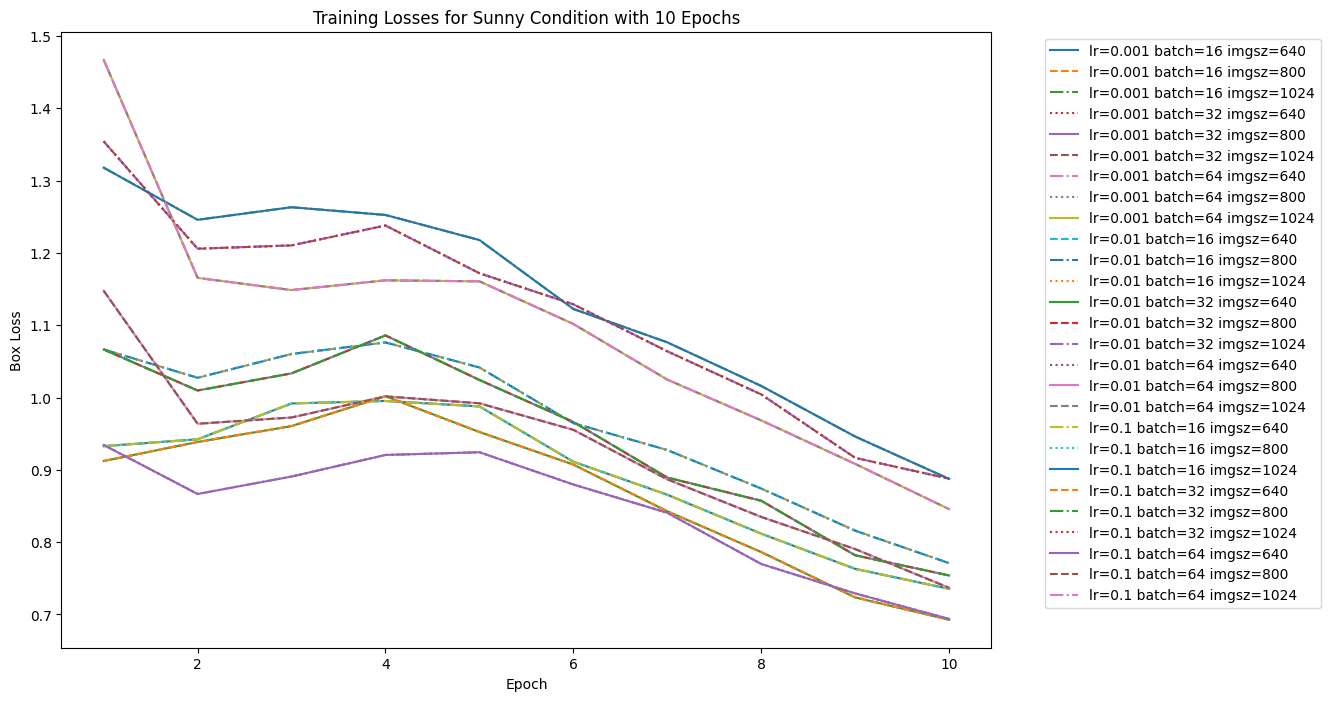

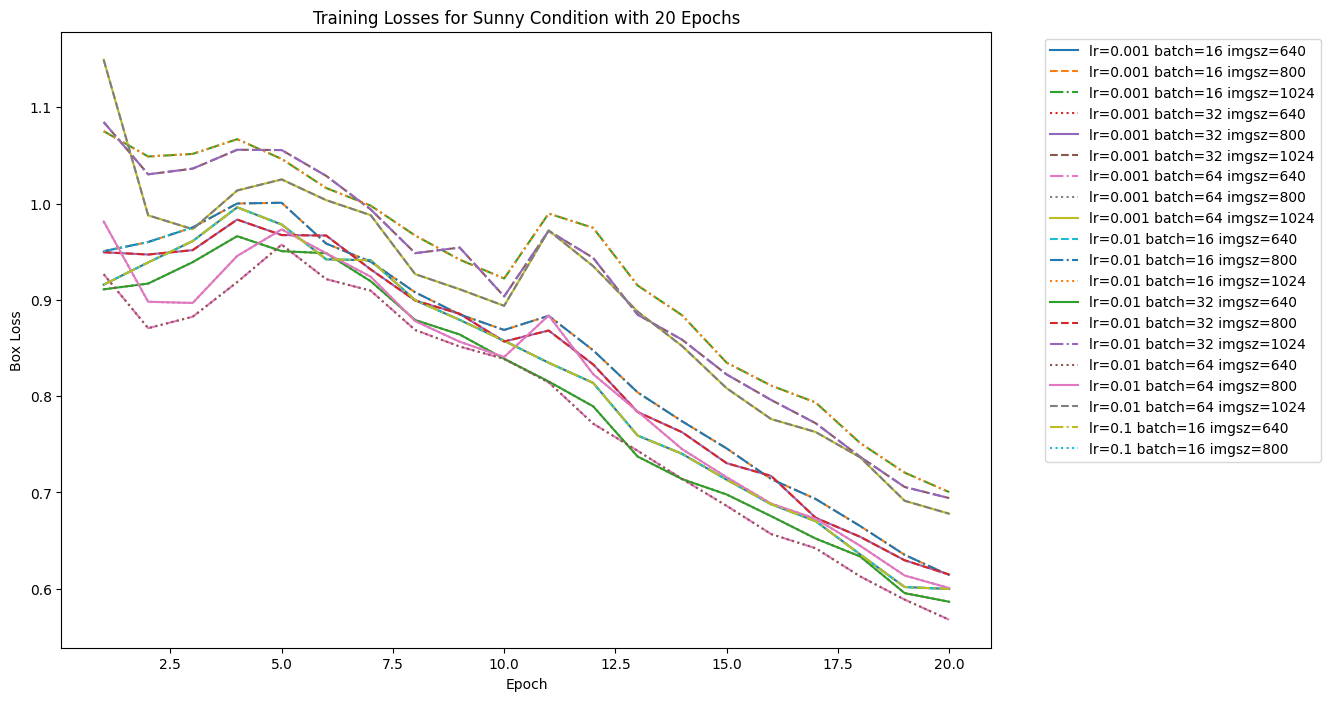

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Function to read the log files and return the data
def read_log_files(output_dir, conditions, epochs_list, learning_rates, batch_sizes, img_sizes):
    logs = []
    for condition in conditions:
        for epochs in epochs_list:
            for lr in learning_rates:
                for batch in batch_sizes:
                    for imgsz in img_sizes:
                        log_dir = f"{output_dir}/{condition}/yolov8_voc2012_{condition}_epochs_{epochs}_lr_{lr}_batch_{batch}_imgsz_{imgsz}/results.csv"
                        if os.path.exists(log_dir):
                            log_data = pd.read_csv(log_dir)
                            log_data.columns = log_data.columns.str.strip()  # Strip whitespace from columns
                            log_data['condition'] = condition
                            log_data['epochs'] = epochs
                            log_data['lr'] = lr
                            log_data['batch'] = batch
                            log_data['imgsz'] = imgsz
                            logs.append(log_data)
                        else:
                            print(f"Log file not found: {log_dir}")
    return pd.concat(logs, ignore_index=True)

# Function to plot losses
def plot_losses_by_condition(logs):
    conditions = logs['condition'].unique()
    for condition in conditions:
        condition_logs = logs[logs['condition'] == condition]
        epochs_list = condition_logs['epochs'].unique()

        for epochs in epochs_list:
            epoch_logs = condition_logs[condition_logs['epochs'] == epochs]
            fig, ax = plt.subplots(figsize=(12, 8))

            line_styles = ['-', '--', '-.', ':']
            style_index = 0

            for (lr, batch, imgsz), group in epoch_logs.groupby(['lr', 'batch', 'imgsz']):
                ax.plot(group['epoch'], group['train/box_loss'], label=f'lr={lr} batch={batch} imgsz={imgsz}', linestyle=line_styles[style_index % len(line_styles)])
                style_index += 1

            ax.set_xlabel('Epoch')
            ax.set_ylabel('Box Loss')
            ax.set_title(f'Training Losses for {condition.capitalize()} Condition with {epochs} Epochs')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()

# Define the parameters
conditions = ['sunny']
epochs_list = [10, 20]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
img_sizes = [640, 800, 1024]

# Read the log files and plot the losses
logs = read_log_files(output_dir, conditions, epochs_list, learning_rates, batch_sizes, img_sizes)
plot_losses_by_condition(logs)


TRAIN MODEL FOR ALL WEATHER TYPE

In [ ]:
from ultralytics import YOLO

def train_model(condition):
    yaml_file = f"{output_dir}/{condition}/voc2012_{condition}.yaml"
    save_dir = f"{output_dir}/{condition}"
    model_name = f'yolov8_voc2012_{condition}'

    model = YOLO('yolov8s.pt') #pretrained model

    # Train the model
    model.train(
        data=yaml_file,
        epochs=20,
        imgsz=640,
        batch=16,
        name=model_name,
        augment=True,
        save_dir=save_dir,  # saving directory
        project = '1',
        device = 'cuda'
    )
    print(f"Training for {condition} condition completed successfully.")


In [ ]:
for condition in conditions:
    print(f"Starting training for {condition} condition...")
    train_model(condition)
    print(f"Finished training for {condition} condition.\n")


Starting training for sunny condition...


100%|██████████| 21.5M/21.5M [00:00<00:00, 408MB/s]


Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/VOC2012/YOLO/sunny/voc2012_sunny.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8_voc2012_sunny, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fa

100%|██████████| 755k/755k [00:00<00:00, 113MB/s]


Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 6.25M/6.25M [00:00<00:00, 396MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/train... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [03:19<00:00,  7.87it/s]


train: New cache created: /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:40<00:00,  9.68it/s]


val: New cache created: /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val.cache
Plotting labels to runs/detect/yolov8_voc2012_sunny/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8_voc2012_sunny
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.93G     0.9157      2.264      1.227          9        640: 100%|██████████| 99/99 [00:14<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.22it/s]

                   all        393        926      0.767      0.638      0.744      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       3.9G     0.9388      1.411      1.238         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]

                   all        393        926      0.708      0.599      0.652      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       3.9G      0.961      1.318      1.258         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.46it/s]

                   all        393        926      0.604      0.517       0.56      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.85G      0.996      1.282       1.27          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.18it/s]

                   all        393        926      0.634      0.509      0.558      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.93G     0.9782      1.256       1.27          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        393        926      0.628      0.553      0.598      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.85G     0.9421      1.141      1.238         17        640: 100%|██████████| 99/99 [00:09<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.86it/s]

                   all        393        926      0.706      0.557      0.624       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.87G     0.9411      1.094      1.237         19        640: 100%|██████████| 99/99 [00:10<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.21it/s]

                   all        393        926      0.678      0.595      0.645      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.88G     0.8997      1.048      1.214          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.47it/s]


                   all        393        926      0.656      0.594      0.639      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.88G     0.8792     0.9983      1.204         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]

                   all        393        926       0.66      0.579      0.649      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.89G     0.8575     0.9387       1.19         18        640: 100%|██████████| 99/99 [00:10<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.18it/s]

                   all        393        926      0.647      0.604      0.624      0.438


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.87G     0.8346     0.8577      1.175          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


                   all        393        926      0.683      0.586      0.657      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.85G     0.8138     0.8064      1.171          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.39it/s]


                   all        393        926       0.69       0.64      0.672      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.87G     0.7591     0.7144      1.125          3        640: 100%|██████████| 99/99 [00:09<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]

                   all        393        926      0.741      0.585      0.671      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.84G     0.7401     0.6656      1.099          3        640: 100%|██████████| 99/99 [00:09<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.32it/s]

                   all        393        926      0.714      0.643        0.7      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.87G     0.7132     0.6357      1.074          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.57it/s]


                   all        393        926      0.756      0.578      0.673      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.86G     0.6878     0.5832      1.065          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.04it/s]

                   all        393        926      0.737      0.596      0.698      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.87G     0.6702     0.5547      1.052          4        640: 100%|██████████| 99/99 [00:09<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]

                   all        393        926      0.757      0.574      0.679       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.84G     0.6357     0.5273      1.027          4        640: 100%|██████████| 99/99 [00:09<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


                   all        393        926      0.774       0.61      0.697      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.87G     0.6018      0.485      1.011          9        640: 100%|██████████| 99/99 [00:10<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.50it/s]

                   all        393        926      0.746      0.628      0.688      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.85G     0.5997     0.4682      1.005          7        640: 100%|██████████| 99/99 [00:09<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.34it/s]

                   all        393        926      0.775      0.621      0.713      0.515



20 epochs completed in 0.074 hours.
Optimizer stripped from runs/detect/yolov8_voc2012_sunny/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8_voc2012_sunny/weights/best.pt, 22.5MB

Validating runs/detect/yolov8_voc2012_sunny/weights/best.pt...
Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


                   all        393        926       0.74      0.701      0.783      0.598
             aeroplane         14         15      0.854      0.779      0.883      0.717
               bicycle         14         16       0.68       0.75      0.812      0.591
                  bird         17         23      0.757      0.696      0.725      0.578
                  boat         16         23      0.601      0.656      0.729      0.413
                bottle         21         30        0.9      0.597      0.734        0.5
                   bus          7         10      0.921        0.9      0.935      0.775
                   car         31         63      0.784      0.693      0.818      0.594
                   cat         21         21      0.772      0.762      0.839      0.686
                 chair         28         48      0.588      0.683      0.673      0.504
                   cow          6         14       0.72      0.571      0.762      0.608
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/train... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [03:08<00:00,  8.34it/s]


train: New cache created: /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/val... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:38<00:00, 10.17it/s]


val: New cache created: /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/val.cache
Plotting labels to runs/detect/yolov8_voc2012_cloudy/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8_voc2012_cloudy
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.17G      0.903       2.26      1.223          9        640: 100%|██████████| 99/99 [00:12<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        393        926      0.718      0.625      0.694      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.93G     0.9296      1.384      1.233         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.24it/s]

                   all        393        926      0.597      0.636      0.648      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       3.9G     0.9526      1.298      1.251         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.31it/s]

                   all        393        926       0.61      0.584       0.61      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.87G     0.9748      1.264      1.256          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.87it/s]

                   all        393        926      0.648      0.535      0.593      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.92G     0.9726      1.239      1.273          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

                   all        393        926      0.704      0.559      0.614      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.85G     0.9434      1.121      1.241         17        640: 100%|██████████| 99/99 [00:10<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.26it/s]

                   all        393        926      0.639      0.555      0.603      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.87G     0.9299      1.074      1.229         19        640: 100%|██████████| 99/99 [00:10<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]

                   all        393        926      0.704      0.539      0.619      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.89G     0.8853      1.027      1.206          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]

                   all        393        926       0.68      0.583      0.615      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.88G     0.8758     0.9714      1.204         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.24it/s]

                   all        393        926      0.756      0.572      0.653      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       3.9G     0.8543     0.9225      1.184         18        640: 100%|██████████| 99/99 [00:10<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.37it/s]

                   all        393        926      0.655      0.607      0.626      0.433


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.87G     0.8208     0.8561      1.175          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]

                   all        393        926      0.715      0.554       0.61      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.86G     0.7901     0.7875      1.151          4        640: 100%|██████████| 99/99 [00:09<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

                   all        393        926      0.647      0.591      0.626      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.88G     0.7599     0.7069      1.126          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.03it/s]

                   all        393        926      0.692      0.595      0.654      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.85G     0.7312     0.6528      1.087          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.27it/s]


                   all        393        926      0.698      0.593      0.664      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.88G     0.6998     0.6186      1.063          4        640: 100%|██████████| 99/99 [00:09<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.86it/s]

                   all        393        926      0.659      0.602      0.661      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.86G     0.6699     0.5628      1.051          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]

                   all        393        926      0.729      0.618      0.683      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.88G       0.66      0.539      1.046          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.62it/s]

                   all        393        926       0.74      0.612      0.692      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.85G     0.6294     0.4966      1.023          4        640: 100%|██████████| 99/99 [00:09<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]

                   all        393        926      0.749      0.625      0.685      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.89G     0.6058     0.4813      1.016          9        640: 100%|██████████| 99/99 [00:10<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]

                   all        393        926      0.768      0.607      0.703      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.87G      0.582       0.46     0.9975          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.60it/s]


                   all        393        926      0.716       0.65        0.7      0.517

20 epochs completed in 0.102 hours.
Optimizer stripped from runs/detect/yolov8_voc2012_cloudy/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8_voc2012_cloudy/weights/best.pt, 22.5MB

Validating runs/detect/yolov8_voc2012_cloudy/weights/best.pt...
Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


                   all        393        926      0.768      0.647      0.717      0.549
             aeroplane         14         15      0.848        0.8      0.852      0.735
               bicycle         14         16      0.829      0.562      0.643      0.495
                  bird         17         23      0.828      0.435      0.518      0.333
                  boat         16         23      0.794      0.505      0.644      0.387
                bottle         21         30      0.942      0.543      0.716      0.446
                   bus          7         10      0.803          1      0.995      0.869
                   car         31         63      0.794      0.732      0.842      0.641
                   cat         21         21      0.617      0.619      0.705      0.586
                 chair         28         48      0.636      0.458      0.558      0.406
                   cow          6         14      0.654      0.857      0.747      0.589
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/train... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [02:49<00:00,  9.28it/s]


train: New cache created: /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/val... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:37<00:00, 10.52it/s]


val: New cache created: /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/val.cache
Plotting labels to runs/detect/yolov8_voc2012_foggy/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8_voc2012_foggy
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.17G     0.9202      2.274      1.231          9        640: 100%|██████████| 99/99 [00:12<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

                   all        393        926      0.713      0.659      0.723      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.96G     0.9468      1.439      1.245         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]

                   all        393        926      0.662      0.537      0.608      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.93G     0.9642      1.333      1.265         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]

                   all        393        926      0.627      0.535      0.611      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       3.9G     0.9977      1.303      1.273          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.48it/s]


                   all        393        926      0.586      0.544      0.581      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.95G     0.9871      1.275      1.281          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


                   all        393        926      0.638       0.53      0.566      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.88G     0.9589      1.141      1.252         17        640: 100%|██████████| 99/99 [00:10<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

                   all        393        926      0.613      0.588      0.623      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.89G     0.9291      1.113      1.236         19        640: 100%|██████████| 99/99 [00:10<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.23it/s]

                   all        393        926      0.673       0.59      0.617      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.92G     0.8977      1.072      1.217          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.35it/s]

                   all        393        926      0.659       0.58      0.617       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.89G     0.8845      1.018      1.215         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]

                   all        393        926      0.718      0.568      0.641      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.91G      0.863     0.9662      1.193         18        640: 100%|██████████| 99/99 [00:10<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.31it/s]

                   all        393        926      0.704       0.62      0.673      0.467


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.89G     0.8432      0.893      1.187          8        640: 100%|██████████| 99/99 [00:12<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.96it/s]

                   all        393        926      0.667      0.598      0.637      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.89G     0.8156     0.8298      1.174          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]

                   all        393        926      0.726      0.602      0.678      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       3.9G     0.7797     0.7538      1.148          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]

                   all        393        926      0.707      0.595      0.662      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.87G     0.7515     0.6994      1.105          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.46it/s]

                   all        393        926      0.706      0.618      0.678      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.89G     0.7112     0.6286      1.077          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.40it/s]


                   all        393        926      0.728      0.623      0.679      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.89G     0.6973      0.596      1.072          8        640: 100%|██████████| 99/99 [00:09<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]

                   all        393        926      0.713      0.605      0.668      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       3.9G     0.6859     0.5892      1.067          4        640: 100%|██████████| 99/99 [00:09<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.37it/s]


                   all        393        926      0.722      0.648      0.704      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.87G     0.6445     0.5429      1.043          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.35it/s]

                   all        393        926      0.733       0.63        0.7      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.89G      0.626     0.5053      1.028          9        640: 100%|██████████| 99/99 [00:10<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

                   all        393        926      0.748      0.656       0.71      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.89G     0.6109     0.4872      1.015          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.43it/s]

                   all        393        926      0.738      0.655      0.705      0.532



20 epochs completed in 0.102 hours.
Optimizer stripped from runs/detect/yolov8_voc2012_foggy/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8_voc2012_foggy/weights/best.pt, 22.5MB

Validating runs/detect/yolov8_voc2012_foggy/weights/best.pt...
Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


                   all        393        926      0.717      0.731      0.764      0.584
             aeroplane         14         15      0.925       0.82      0.905      0.754
               bicycle         14         16      0.676       0.75      0.798      0.543
                  bird         17         23      0.834      0.609      0.727      0.589
                  boat         16         23      0.875      0.522      0.712      0.467
                bottle         21         30       0.68      0.567      0.619      0.381
                   bus          7         10      0.804        0.9      0.882      0.735
                   car         31         63      0.781      0.825      0.871      0.653
                   cat         21         21      0.735      0.857      0.865      0.729
                 chair         28         48      0.571      0.609      0.694      0.491
                   cow          6         14      0.668      0.864      0.844      0.694
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/train.cache... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8_voc2012_rainy/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8_voc2012_rainy
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.15G     0.9282       2.28      1.234          9        640: 100%|██████████| 99/99 [00:44<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:14<00:00,  1.08s/it]

                   all        393        926      0.677      0.642      0.684      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.96G     0.9368      1.415      1.244         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]


                   all        393        926       0.66      0.596      0.642      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.93G     0.9655      1.316       1.26         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

                   all        393        926      0.627      0.589      0.635      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.89G     0.9952      1.269      1.274          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]

                   all        393        926      0.698       0.54      0.612      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.95G     0.9762      1.263      1.273          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.36it/s]


                   all        393        926      0.617      0.545      0.595      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.87G     0.9541      1.143      1.251         17        640: 100%|██████████| 99/99 [00:10<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.19it/s]

                   all        393        926       0.65      0.552      0.601      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.89G     0.9246       1.09      1.235         19        640: 100%|██████████| 99/99 [00:10<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.96it/s]

                   all        393        926      0.615      0.621      0.633      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.92G     0.8984       1.04      1.218          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.27it/s]

                   all        393        926      0.637      0.625      0.646      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       3.9G     0.8745     0.9758      1.208         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.30it/s]

                   all        393        926      0.718      0.587      0.649      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.91G     0.8549     0.9347      1.192         18        640: 100%|██████████| 99/99 [00:10<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]

                   all        393        926      0.719      0.583      0.652      0.463


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.89G     0.8314     0.8723      1.181          8        640: 100%|██████████| 99/99 [00:11<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.27it/s]

                   all        393        926      0.725      0.594      0.652      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.89G     0.7998      0.797      1.158          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.41it/s]

                   all        393        926      0.729      0.576      0.656      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       3.9G      0.751     0.7291      1.121          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.39it/s]

                   all        393        926      0.707      0.582      0.646      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.87G     0.7236     0.6633      1.094          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


                   all        393        926      0.733      0.597      0.686      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.89G     0.7093     0.6245      1.069          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.19it/s]


                   all        393        926      0.688      0.616      0.659       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.89G     0.6788     0.5736      1.058          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.02it/s]

                   all        393        926      0.724      0.631      0.691      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       3.9G     0.6652     0.5485       1.05          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.16it/s]

                   all        393        926      0.754       0.63      0.713      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.87G     0.6388     0.5156      1.032          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.00it/s]

                   all        393        926      0.787      0.664      0.724      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.89G     0.6025     0.4789      1.012          9        640: 100%|██████████| 99/99 [00:10<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.37it/s]

                   all        393        926      0.806      0.647      0.729      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.89G     0.5888     0.4598          1          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


                   all        393        926      0.787      0.654      0.727       0.54

20 epochs completed in 0.115 hours.
Optimizer stripped from runs/detect/yolov8_voc2012_rainy/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8_voc2012_rainy/weights/best.pt, 22.5MB

Validating runs/detect/yolov8_voc2012_rainy/weights/best.pt...
Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


                   all        393        926       0.77      0.648      0.734      0.563
             aeroplane         14         15      0.849        0.8      0.849      0.753
               bicycle         14         16      0.851      0.562       0.71      0.505
                  bird         17         23      0.679       0.46      0.539      0.439
                  boat         16         23      0.771      0.435      0.643      0.385
                bottle         21         30      0.902        0.5        0.7      0.457
                   bus          7         10      0.897      0.875      0.952       0.84
                   car         31         63      0.802       0.73      0.844      0.646
                   cat         21         21      0.767      0.626      0.763      0.534
                 chair         28         48      0.702      0.438      0.568      0.392
                   cow          6         14      0.714      0.929      0.864      0.621
           diningtabl

train: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/train... 1570 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1570/1570 [02:53<00:00,  9.05it/s]


train: New cache created: /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/val... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


val: New cache created: /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/val.cache
Plotting labels to runs/detect/yolov8_voc2012_snowy/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8_voc2012_snowy
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.17G      0.901      2.224      1.221         13        640: 100%|██████████| 99/99 [00:13<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.96it/s]

                   all        393        967      0.638      0.632      0.693      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.95G     0.9224      1.392      1.236          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]

                   all        393        967      0.612      0.595      0.649      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       3.9G     0.9616      1.308      1.247         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


                   all        393        967       0.66      0.448      0.552      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.92G     0.9829      1.297      1.277          5        640: 100%|██████████| 99/99 [00:10<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.27it/s]

                   all        393        967      0.609      0.519      0.553      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.93G     0.9688      1.227      1.275          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]

                   all        393        967      0.569      0.529      0.571       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.89G     0.9507      1.186      1.251         13        640: 100%|██████████| 99/99 [00:10<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.27it/s]

                   all        393        967      0.559      0.569      0.596      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.89G     0.9336      1.098      1.239         18        640: 100%|██████████| 99/99 [00:10<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]

                   all        393        967      0.592      0.554      0.592      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.92G     0.8925       1.04      1.213          8        640: 100%|██████████| 99/99 [00:10<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]

                   all        393        967      0.773      0.578      0.645      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.92G     0.8624     0.9645      1.192         10        640: 100%|██████████| 99/99 [00:10<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]

                   all        393        967      0.659      0.556      0.617      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.89G     0.8414     0.9287      1.182         11        640: 100%|██████████| 99/99 [00:10<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.38it/s]


                   all        393        967      0.664      0.574      0.637      0.428
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.89G     0.8284     0.8562      1.169          3        640: 100%|██████████| 99/99 [00:12<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.20it/s]

                   all        393        967      0.648      0.563      0.614      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.88G     0.7969     0.7973      1.153          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]

                   all        393        967      0.688       0.58      0.633      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       3.9G     0.7568     0.7297      1.124          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.03it/s]

                   all        393        967      0.722      0.581      0.653      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.87G     0.7212     0.6648      1.091          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


                   all        393        967      0.734      0.609      0.683      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.88G     0.7001     0.6028      1.064          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]

                   all        393        967      0.703       0.63      0.683      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.89G     0.6651      0.566      1.054          7        640: 100%|██████████| 99/99 [00:10<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]

                   all        393        967      0.733      0.607      0.696      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       3.9G     0.6461     0.5252      1.035          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.26it/s]


                   all        393        967      0.694      0.634      0.685      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.87G     0.6255     0.5015      1.022          3        640: 100%|██████████| 99/99 [00:10<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.00it/s]


                   all        393        967      0.656      0.655      0.683      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.89G     0.6071     0.4743      1.018          4        640: 100%|██████████| 99/99 [00:10<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]

                   all        393        967       0.76      0.611      0.701      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.89G     0.5887     0.4563      1.003          6        640: 100%|██████████| 99/99 [00:10<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.57it/s]


                   all        393        967      0.738      0.644      0.708      0.505

20 epochs completed in 0.103 hours.
Optimizer stripped from runs/detect/yolov8_voc2012_snowy/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8_voc2012_snowy/weights/best.pt, 22.5MB

Validating runs/detect/yolov8_voc2012_snowy/weights/best.pt...
Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


                   all        393        967      0.735      0.672      0.735      0.536
             aeroplane         14         16      0.847      0.688      0.808        0.7
               bicycle         11         12      0.742      0.833      0.912      0.716
                  bird         17         21      0.694      0.714      0.809      0.571
                  boat         20         34      0.723      0.706       0.69      0.455
                bottle         22         28      0.843      0.768      0.815      0.578
                   bus          7          7       0.53      0.571      0.553      0.414
                   car         35         61      0.809      0.754       0.81      0.549
                   cat         25         27      0.819      0.671      0.823      0.594
                 chair         41         87      0.578      0.473      0.533       0.36
                   cow         15         31      0.843      0.694      0.843      0.632
           diningtabl

In [ ]:
import pandas as pd

# Define a sample path to one of your log files
sample_log_path = '/content/drive/MyDrive/VOC2012/YOLO/cloudy/yolov8_voc2012_cloudy/results.csv'

# Load and inspect the CSV file
sample_log = pd.read_csv(sample_log_path)
print(sample_log.columns)


Index(['                  epoch', '         train/box_loss',
       '         train/cls_loss', '         train/dfl_loss',
       '   metrics/precision(B)', '      metrics/recall(B)',
       '       metrics/mAP50(B)', '    metrics/mAP50-95(B)',
       '           val/box_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')


GET WEIGHT FILES FOR INFERENCE

In [ ]:
# Define base path and conditions
base_path = '/content/drive/MyDrive/VOC2012/YOLO'
conditions = ['sunny', 'cloudy', 'foggy', 'rainy', 'snowy']

# Function to get the weights file path for a given condition
def get_weights_path(condition):
    return f"{base_path}/{condition}/yolov8_voc2012_{condition}/weights/best.pt"


In [ ]:
# from ultralytics import YOLO

# def run_inference(condition, img_path):
#     weights_path = get_weights_path(condition)
#     print(f"Loading weights from: {weights_path}")

#     # Load the model with the specified weights
#     model = YOLO(weights_path)

#     # Run inference
#     results = model(img_path)

#     # Display results
#     results.show()
#     return results


In [ ]:
from ultralytics import YOLO


INFERENCE FUNCTION

In [ ]:
def run_inference(condition, img_dir):
    weights_path = get_weights_path(condition)
    print(f"Loading weights from: {weights_path}")

    # Load the model with the specified weights
    model = YOLO(weights_path)

    # Get list of image paths
    img_paths = glob.glob(f"{img_dir}/*.jpg")

    # Check if images are found
    if not img_paths:
        print(f"No images found in {img_dir}")
        return

    # Run inference on each image and display results
    for img_path in img_paths:
        print(f"Running inference on {img_path}")
        results = model(img_path)

        # Display results for each image
        for result in results:
            result.show()


WEATHER MAPPING FUNCTION

In [ ]:
def categorize_weather(api_weather):
    weather_mapping = {
        'sunny': ['clear', 'sun', 'sunny', 'mostly sunny', 'partly sunny', 'fair'],
        'cloudy': ['cloud', 'cloudy', 'overcast', 'mostly cloudy', 'partly cloudy'],
        'foggy': ['fog', 'mist', 'haze', 'foggy', 'misty'],
        'rainy': ['rain', 'rainy', 'drizzle', 'showers', 'thunderstorm', 'light rain', 'heavy rain'],
        'snowy': ['snow', 'snowy', 'sleet', 'blizzard', 'snow showers', 'light snow', 'heavy snow']
    }

    # Normalize the input to lowercase
    api_weather = api_weather.lower()

    # Check the weather description and map it to the predefined categories
    for category, keywords in weather_mapping.items():
        for keyword in keywords:
            if keyword in api_weather:
                return category

    # Default to 'cloudy' if no match is found
    return 'cloudy'


WEATHER API FUNCTION

In [ ]:
import requests

def get_weather(api_key, location):
    url = f"http://api.weatherapi.com/v1/current.json?key={api_key}&q={location}&aqi=no"
    response = requests.get(url)
    if response.status_code == 200:
        weather_data = response.json()
        if 'current' in weather_data:
            condition = weather_data['current']['condition']['text']
            cetegorized_weather = categorize_weather(condition)
            return cetegorized_weather
        else:
            print("Weather data not found in the response.")
            return None
    else:
        print(f"Error fetching weather data: {response.status_code}")
        return None

In [ ]:
# Fetch current weather condition
api_key = 'aaa94b2ae6e8483a95a135306240108'  # My API key
location = 'mumbai'  # Dummy Location
current_weather = get_weather(api_key, location)
print(current_weather)

rainy


***MODEL EVALUATION***
---




Install Library for TTS

In [ ]:
import subprocess

def install_packages():
    subprocess.check_call(['apt-get', 'update'])
    subprocess.check_call(['apt-get', 'install', '-y', 'libespeak1'])
    subprocess.check_call(['pip', 'install', 'pillow', 'pytesseract', 'gtts', 'mutagen'])

# Install necessary packages
install_packages()


Generate Description Function

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random
import glob
from PIL import Image
from gtts import gTTS
from mutagen.mp3 import MP3
from IPython.display import Audio, display
from collections import Counter
from time import sleep

# Function to generate a natural language description from YOLO predictions
def generate_description(predictions, model):
    descriptions = []
    for result in predictions:
        classes_detected = [model.names[int(bbox.cls)] for bbox in result.boxes]
        count_classes = Counter(classes_detected)
        for class_name, count in count_classes.items():
            if count > 3:
                descriptions.append(f"a group of {class_name}s")
            elif count > 1:
                descriptions.append(f"{count} {class_name}s")
            else:
                descriptions.append(f"{count} {class_name}")

    description = "There is " + ", ".join(descriptions) + " in front of you."
    return description


# Function to convert text to speech using gTTS
def speak_text(description):
    tts = gTTS(description, lang='en')
    tts.save("description.mp3")
    audio = MP3("description.mp3")
    audio_length = audio.info.length
    display(Audio("description.mp3", autoplay=True))
    sleep(audio_length)


Conversion to Speech

In [ ]:
from ultralytics import YOLO

def run_inference_and_speech(model, image_files, num_samples=5):
    # Randomly select `num_samples` images from the list
    sample_images = random.sample(image_files, num_samples)

    for image_file in sample_images:
        img = cv2.imread(image_file)
        results = model.predict(source=img)
        result_img = results[0].plot()

        # Generate description
        description = generate_description(results, model)

        # Print description for debugging
        print(f"Description: {description}")

        # Display the image with predictions
        plt.figure(figsize=(10, 10))
        plt.imshow(result_img)
        plt.title(f"Inference result for {image_file}")
        plt.axis('off')
        plt.show()

        # Convert description to speech
        speak_text(description)


Define base path for the dataset

In [ ]:
# Define base path and conditions
base_path = '/content/drive/MyDrive/VOC2012/YOLO'
conditions = ['sunny', 'cloudy', 'foggy', 'rainy', 'snowy']

# Function to get the weights file path for a given condition
def get_weights_path(condition):
    return f"{base_path}/{condition}/yolov8_voc2012_{condition}/weights/best.pt"

***RESULTS - BASED ON CURRENT WEATHER***
---

Categorized current weather: rainy

0: 512x640 1 bottle, 1 person, 533.9ms
Speed: 5.8ms preprocess, 533.9ms inference, 14.0ms postprocess per image at shape (1, 3, 512, 640)
Description: There is 1 person, 1 bottle in front of you.


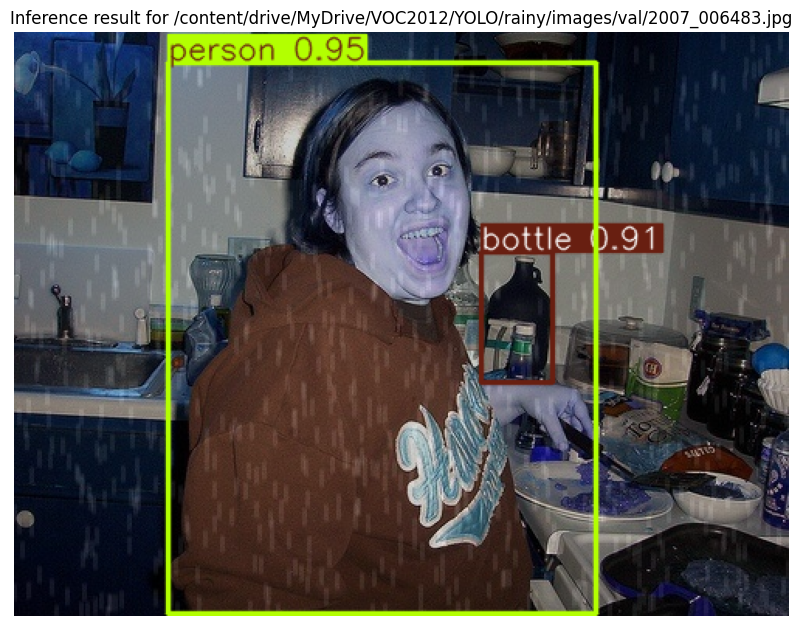


0: 448x640 1 car, 426.8ms
Speed: 6.6ms preprocess, 426.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Description: There is 1 car in front of you.


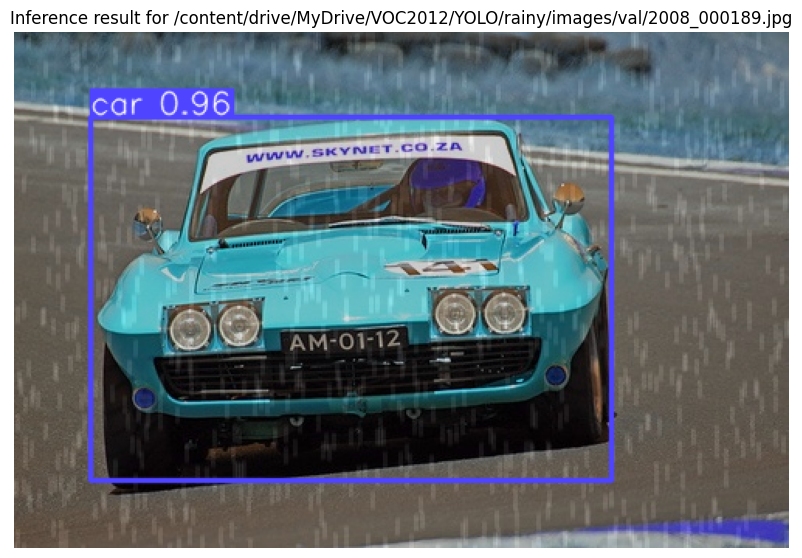


0: 480x640 1 dog, 1 person, 469.8ms
Speed: 5.0ms preprocess, 469.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
Description: There is 1 person, 1 dog in front of you.


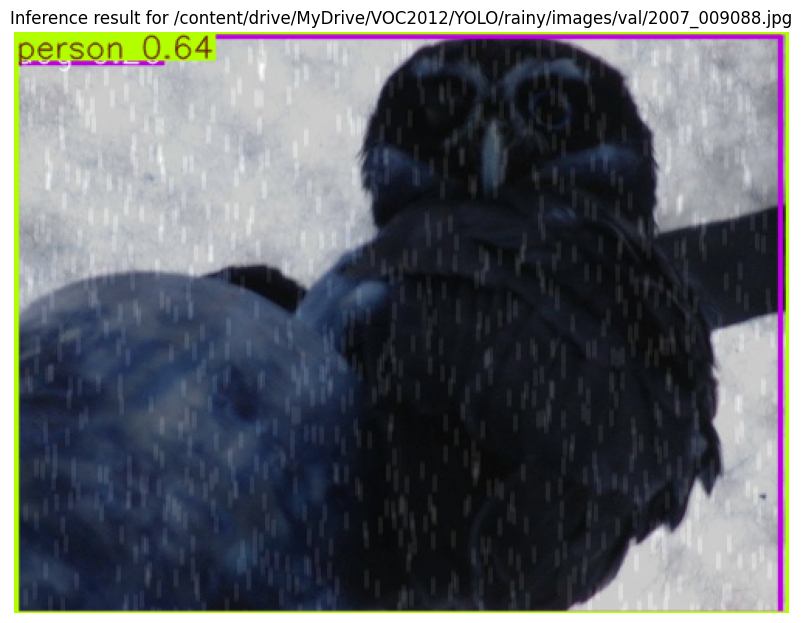


0: 640x480 1 diningtable, 782.6ms
Speed: 5.3ms preprocess, 782.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
Description: There is 1 diningtable in front of you.


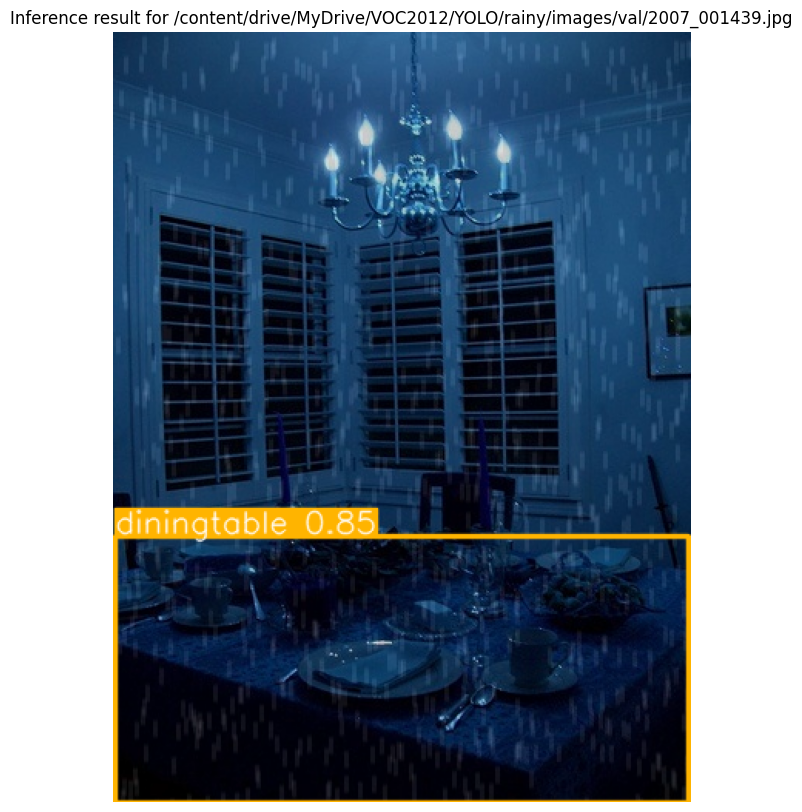


0: 480x640 1 chair, 2 persons, 463.4ms
Speed: 4.1ms preprocess, 463.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
Description: There is 2 persons, 1 chair in front of you.


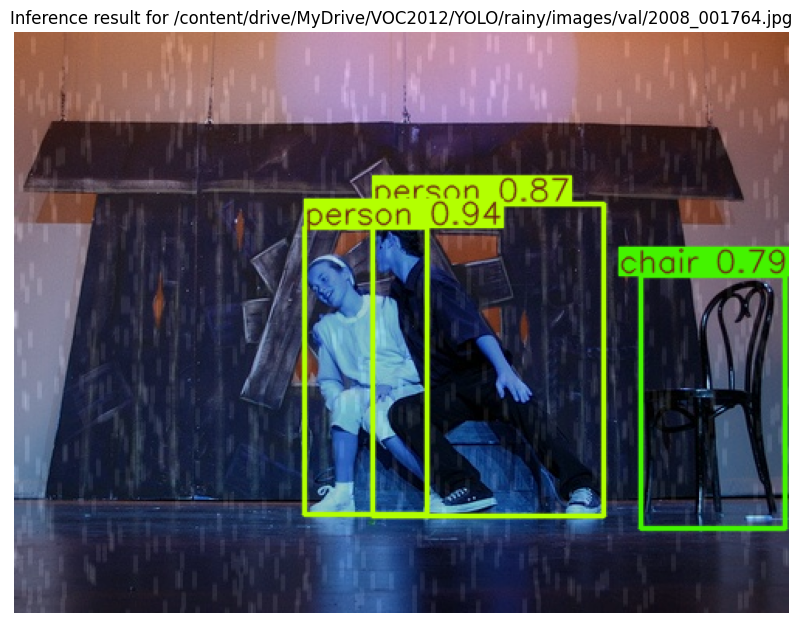

In [ ]:
import requests
import glob

# Function to categorize weather
def categorize_weather(api_weather):
    weather_mapping = {
        'sunny': ['clear', 'sun', 'sunny', 'mostly sunny', 'partly sunny', 'fair'],
        'cloudy': ['cloud', 'cloudy', 'overcast', 'mostly cloudy', 'partly cloudy'],
        'foggy': ['fog', 'mist', 'haze', 'foggy', 'misty'],
        'rainy': ['rain', 'rainy', 'drizzle', 'showers', 'thunderstorm', 'light rain', 'heavy rain'],
        'snowy': ['snow', 'snowy', 'sleet', 'blizzard', 'snow showers', 'light snow', 'heavy snow']
    }

    # Normalize the input to lowercase
    api_weather = api_weather.lower()

    # Check the weather description and map it to the predefined categories
    for category, keywords in weather_mapping.items():
        for keyword in keywords:
            if keyword in api_weather:
                return category

    # Default to 'cloudy' if no match is found
    return 'cloudy'

# Function to get and categorize weather
def get_and_categorize_weather(api_key, location):
    url = f"http://api.weatherapi.com/v1/current.json?key={api_key}&q={location}&aqi=no"
    response = requests.get(url)
    if response.status_code == 200:
        weather_data = response.json()
        if 'current' in weather_data:
            condition = weather_data['current']['condition']['text']
            return categorize_weather(condition)
        else:
            print("Weather data not found in the response.")
            return None
    else:
        print(f"Error fetching weather data: {response.status_code}")
        return None

# API key and location
api_key = 'aaa94b2ae6e8483a95a135306240108'  # my API key
location = 'mumbai'  # Dummy location

# Get and categorize current weather
current_weather_category = get_and_categorize_weather(api_key, location)
print(f"Categorized current weather: {current_weather_category}")

# Load the model with weights for the current weather
weights_path = f"/content/drive/MyDrive/VOC2012/YOLO/{current_weather_category}/yolov8_voc2012_{current_weather_category}/weights/best.pt"
model = YOLO(weights_path)

# Directory containing test images
img_dir = f"/content/drive/MyDrive/VOC2012/YOLO/{current_weather_category}/images/val/"
test_image_files = glob.glob(f"{img_dir}/*.jpg")

# Run inference on a random sample of images and convert to speech
run_inference_and_speech(model, test_image_files)


Saving results to csv file

In [ ]:
import os
from ultralytics import YOLO
import pandas as pd

# Define paths and conditions
output_dir = '/content/drive/MyDrive/VOC2012/YOLO'
conditions = ['sunny', 'cloudy', 'foggy', 'rainy', 'snowy']
classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
           "bus", "car", "cat", "chair", "cow",
           "diningtable", "dog", "horse", "motorbike", "person",
           "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

# Function to get the weights file path for a given condition
def get_weights_path(condition):
    return f"{output_dir}/{condition}/yolov8_voc2012_{condition}/weights/best.pt"

# Function to load the model, validate it, and get the metrics
def get_metrics(condition):
    weights_path = get_weights_path(condition)
    if os.path.exists(weights_path):
        model = YOLO(weights_path)
        results = model.val()

        # Extracting mean metrics
        mean_precision = results.box.map50
        mean_recall = results.box.mr
        mean_map50 = results.box.map50
        mean_map5095 = results.box.map

        # Calculate F1 score
        mean_f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)

        metrics = {
            'condition': condition,
            'mAP@0.5': mean_map50,
            'mAP@0.5:0.95': mean_map5095,
            'F1 Score': mean_f1_score,
            'Precision': mean_precision,
            'Recall': mean_recall
        }
        return metrics
    else:
        print(f"Best model not found for condition: {condition}")
        return None

# Get metrics for all conditions
all_metrics = []
for condition in conditions:
    metrics = get_metrics(condition)
    if metrics:
        all_metrics.append(metrics)

# Convert metrics to DataFrame and print it
metrics_df = pd.DataFrame(all_metrics)

# Print the metrics in a table format
print(metrics_df.to_string(index=False))

# Optionally, save the DataFrame to a CSV file
metrics_df.to_csv(f"{output_dir}/metrics_summary.csv", index=False)


Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/VOC2012/YOLO/sunny/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [03:42<00:00,  8.88s/it]


                   all        393        926      0.754      0.642       0.74      0.546
             aeroplane         14         15      0.919      0.753      0.915      0.665
               bicycle         14         16      0.633      0.625      0.714      0.547
                  bird         17         23      0.671       0.62      0.661      0.428
                  boat         16         23       0.72      0.696      0.718      0.386
                bottle         21         30      0.894       0.56      0.736      0.503
                   bus          7         10      0.762        0.7      0.785      0.668
                   car         31         63      0.873      0.653      0.793      0.562
                   cat         21         21      0.844      0.774      0.797      0.613
                 chair         28         48      0.533      0.646      0.642      0.481
                   cow          6         14      0.589      0.512      0.716      0.558
           diningtabl

val: Scanning /content/drive/MyDrive/VOC2012/YOLO/cloudy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [03:33<00:00,  8.52s/it]


                   all        393        926      0.727      0.657      0.708      0.524
             aeroplane         14         15      0.919        0.8      0.862      0.681
               bicycle         14         16      0.647      0.625      0.673      0.466
                  bird         17         23      0.769      0.434      0.497       0.38
                  boat         16         23      0.732      0.594      0.695      0.393
                bottle         21         30      0.762      0.533      0.709      0.424
                   bus          7         10      0.639        0.7      0.856      0.722
                   car         31         63      0.826      0.762      0.835      0.593
                   cat         21         21      0.792      0.714      0.798      0.585
                 chair         28         48      0.627      0.438      0.518       0.34
                   cow          6         14      0.796      0.929      0.822      0.626
           diningtabl

val: Scanning /content/drive/MyDrive/VOC2012/YOLO/foggy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [03:36<00:00,  8.67s/it]


                   all        393        926        0.7      0.666      0.721      0.546
             aeroplane         14         15      0.749      0.667      0.761      0.646
               bicycle         14         16      0.562      0.562      0.688      0.545
                  bird         17         23      0.783      0.565      0.641      0.501
                  boat         16         23      0.726      0.522      0.642      0.395
                bottle         21         30      0.785      0.487       0.64      0.427
                   bus          7         10      0.885      0.774      0.824      0.586
                   car         31         63      0.798      0.751      0.812      0.615
                   cat         21         21      0.844      0.775       0.84      0.642
                 chair         28         48      0.508      0.583      0.627      0.474
                   cow          6         14      0.802      0.929      0.869      0.705
           diningtabl

val: Scanning /content/drive/MyDrive/VOC2012/YOLO/rainy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [03:33<00:00,  8.53s/it]


                   all        393        926        0.8      0.643      0.725      0.537
             aeroplane         14         15      0.913        0.8      0.842      0.592
               bicycle         14         16      0.867      0.562      0.648      0.451
                  bird         17         23      0.726      0.391      0.509      0.387
                  boat         16         23      0.672      0.478      0.658      0.344
                bottle         21         30      0.906        0.5      0.668      0.431
                   bus          7         10      0.829        0.7      0.798      0.718
                   car         31         63       0.84      0.749      0.821      0.627
                   cat         21         21      0.746      0.714      0.813      0.527
                 chair         28         48      0.795      0.404      0.536      0.405
                   cow          6         14      0.749      0.857      0.837      0.593
           diningtabl

val: Scanning /content/drive/MyDrive/VOC2012/YOLO/snowy/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [03:40<00:00,  8.82s/it]


                   all        393        967      0.734      0.647      0.707      0.505
             aeroplane         14         16      0.875      0.688      0.756      0.643
               bicycle         11         12      0.723       0.87       0.88      0.664
                  bird         17         21      0.617      0.667       0.71      0.473
                  boat         20         34      0.798      0.581      0.623      0.408
                bottle         22         28      0.799      0.679      0.732      0.522
                   bus          7          7      0.742      0.414      0.563      0.365
                   car         35         61      0.824      0.754      0.812      0.583
                   cat         25         27      0.857      0.704      0.819      0.542
                 chair         41         87      0.733      0.411      0.544      0.363
                   cow         15         31      0.832      0.677      0.838      0.641
           diningtabl